### Neo4j Connection

In [3]:
# import the neo4j driver for Python
from neo4j import GraphDatabase


# Database Credentials
uri             = "neo4j://localhost:7687" # Neo4j Sandbox
userName        = "neo4j"
password        = "R0b3n$0n"
 
# Connect to the neo4j database server
graphDB_conn  = GraphDatabase.driver(uri, auth=(userName, password))


### General Import

In [1]:
import pandas as pd
import pickle
import os
import import_ipynb
import altair as alt
from sklearn.manifold import TSNE
from numpy.linalg import eigh
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
%run ./helper_functions/shared_functions_basic.ipynb
# cmd to show the plot.
%matplotlib inline

### Import the profile of the customers

In [39]:
DIR_INPUT='./Baseline/simulation_data/customer_profile/customer_profile.pkl'

customer_df= pd.read_pickle(DIR_INPUT)

customer_df

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[29, 87, 128, 143, 144, 145, 164, 241, 270, 27...",320
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[0, 5, 8, 46, 117, 160, 190, 242, 278, 344, 35...",316
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[38, 51, 228, 235, 316, 406, 447, 449, 523, 52...",220
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[63, 65, 94, 99, 113, 197, 245, 259, 364, 401,...",290
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[19, 53, 57, 213, 320, 345, 372, 535, 548, 614...",200
...,...,...,...,...,...,...,...,...
995,995,43.216661,36.225882,58.023111,29.011555,0.305376,"[134, 135, 215, 264, 309, 319, 352, 395, 412, ...",289
996,996,4.034602,51.110309,7.707631,3.853816,0.238208,"[22, 32, 83, 107, 118, 123, 194, 204, 239, 280...",237
997,997,37.634146,6.177907,41.619615,20.809807,0.967002,"[147, 148, 185, 196, 212, 325, 381, 408, 413, ...",272
998,998,18.777030,40.467983,16.390871,8.195436,1.398557,"[3, 15, 22, 30, 110, 138, 152, 157, 298, 355, ...",282


500 customers profile have been created.

### Creation of the nodes "Customer"

In [40]:
with graphDB_conn.session() as graphDB:
    for index, row in customer_df.iterrows():
        graphDB.run('''MERGE (c:Customer {customerId:$id,latitude:$Lat,longitude:$Long,meanAmount:$MeanAmount, stdAmount:$STDAmount, meanNb_tx_per_day:$MeanTxDay})''',\
                    parameters = {'id': int(row['CUSTOMER_ID']), \
                          'Lat': float(row['x_customer_id']), \
                          'Long': float(row['y_customer_id']), \
                          'MeanAmount': float(row['mean_amount']),\
                          'STDAmount': float(row['std_amount']),\
                          'MeanTxDay': float(row['mean_nb_tx_per_day']) })
    

In [5]:
graphDB_conn.session().run('''MATCH (c: Customer) RETURN c LIMIT 10''').data()

[{'c': {'latitude': 54.88135039273247,
   'customerId': 0,
   'meanNb_tx_per_day': 2.1795327319875875,
   'meanAmount': 62.262520726806166,
   'stdAmount': 31.131260363403083,
   'longitude': 71.51893663724195}},
 {'c': {'latitude': 42.36547993389047,
   'customerId': 1,
   'meanNb_tx_per_day': 3.567092003128319,
   'meanAmount': 46.57078506995579,
   'stdAmount': 23.285392534977895,
   'longitude': 64.58941130666561}},
 {'c': {'latitude': 96.36627605010293,
   'customerId': 2,
   'meanNb_tx_per_day': 2.115579679011618,
   'meanAmount': 80.21387861785314,
   'stdAmount': 40.10693930892657,
   'longitude': 38.34415188257777}},
 {'c': {'latitude': 56.80445610939323,
   'customerId': 3,
   'meanNb_tx_per_day': 0.34851719880616283,
   'meanAmount': 11.74842552879926,
   'stdAmount': 5.87421276439963,
   'longitude': 92.5596638292661}},
 {'c': {'latitude': 2.021839744032572,
   'customerId': 4,
   'meanNb_tx_per_day': 3.4800485929872766,
   'meanAmount': 78.9248913402358,
   'stdAmount': 39

By running this query into Neo4j, we will have 10 Nodes displayed.

<img src="images/Customer_Nodes.png" alt="Text"/>

### Import the terminals information

In [33]:
DIR='./Baseline/simulation_data/terminal/terminal.pkl'

terminal_df= pd.read_pickle(DIR)

terminal_df

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,41.702200,72.032449
1,1,0.011437,30.233257
2,2,14.675589,9.233859
3,3,18.626021,34.556073
4,4,39.676747,53.881673
...,...,...,...
9995,9995,51.537235,82.494454
9996,9996,72.697960,50.144796
9997,9997,5.234608,17.494463
9998,9998,45.335220,4.518896


1000 terminals have been created

### Creation of the nodes "Terminal"

In [41]:
with graphDB_conn.session() as graphDB:
    for index, row in terminal_df.iterrows():
        graphDB.run('''MERGE (a:Terminal {terminalId:$id,latitude:$Lat,longitude:$Long})''', \
                    parameters = {'id': int(row['TERMINAL_ID']), \
                          'Lat': float(row['x_terminal_id']), \
                          'Long': float(row['y_terminal_id'])})


In [8]:
graphDB_conn.session().run('''MATCH (t: Terminal) RETURN t LIMIT 10''').data()

[{'t': {'terminalId': 0,
   'latitude': 41.7022004702574,
   'longitude': 72.0324493442158}},
 {'t': {'terminalId': 1,
   'latitude': 0.011437481734488664,
   'longitude': 30.233257263183976}},
 {'t': {'terminalId': 2,
   'latitude': 14.675589081711305,
   'longitude': 9.233859476879779}},
 {'t': {'terminalId': 3,
   'latitude': 18.62602113776709,
   'longitude': 34.556072704304775}},
 {'t': {'terminalId': 4,
   'latitude': 39.67674742306699,
   'longitude': 53.88167340033569}},
 {'t': {'terminalId': 5,
   'latitude': 41.91945144032948,
   'longitude': 68.52195003967594}},
 {'t': {'terminalId': 6,
   'latitude': 20.445224973151742,
   'longitude': 87.81174363909454}},
 {'t': {'terminalId': 7,
   'latitude': 2.7387593197926163,
   'longitude': 67.04675101784022}},
 {'t': {'terminalId': 8,
   'latitude': 41.730480236712694,
   'longitude': 55.868982844575164}},
 {'t': {'terminalId': 9,
   'latitude': 14.038693859523377,
   'longitude': 19.81014890848788}}]

By running this query into Neo4j, we will have 10 terminal Nodes displayed.

<img src="images/Terminal_Nodes.png" alt="Text"/>

### Creation of the relationship "CONNECTED" between Customer and terminal in a radius = 50

In [42]:
with graphDB_conn.session() as graphDB:
    for index, row in customer_df.iterrows():
        graphDB.run('''MATCH (t:Terminal),(c:Customer) WHERE t.terminalId in $Idterm AND c.customerId=$idcust MERGE (c)-[:CONNECTED]-(t)''', \
                    parameters = {'idcust': int(row['CUSTOMER_ID']), \
                          'Idterm': [ int(idterm) for idterm in row['available_terminals']]})

In [10]:
graphDB_conn.session().run('''MATCH p=(c:Customer)-[:CONNECTED]-(:Terminal)
WHERE c.customerId=1
RETURN p''').data()

[{'p': [{'latitude': 42.36547993389047,
    'customerId': 1,
    'meanNb_tx_per_day': 3.567092003128319,
    'meanAmount': 46.57078506995579,
    'stdAmount': 23.285392534977895,
    'longitude': 64.58941130666561},
   'CONNECTED',
   {'terminalId': 958,
    'latitude': 42.572441198511626,
    'longitude': 60.200783847200135}]},
 {'p': [{'latitude': 42.36547993389047,
    'customerId': 1,
    'meanNb_tx_per_day': 3.567092003128319,
    'meanAmount': 46.57078506995579,
    'stdAmount': 23.285392534977895,
    'longitude': 64.58941130666561},
   'CONNECTED',
   {'terminalId': 943,
    'latitude': 41.367016420136025,
    'longitude': 68.43096218313198}]},
 {'p': [{'latitude': 42.36547993389047,
    'customerId': 1,
    'meanNb_tx_per_day': 3.567092003128319,
    'meanAmount': 46.57078506995579,
    'stdAmount': 23.285392534977895,
    'longitude': 64.58941130666561},
   'CONNECTED',
   {'terminalId': 936,
    'latitude': 46.75500530653396,
    'longitude': 66.69425431939752}]},
 {'p': [{'

By running this query into Neo4j, we get the relationship between a customer and the terminals around.

<img src="images/Relationship Customer-Terminal.png" alt="Text"/>

The customer id=1 has connection with 12 terminals in a radius=5

### Import the transaction of 2 days.

In [7]:
DIR_INPUT='./Baseline/simulation_data/transformed_features/' 

BEGIN_DATE = "2018-04-01"
END_DATE = "2018-05-15"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)

Load  files
Wall time: 1.54 s


In [8]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2018-04-01 00:07:56,2,316,146.00,476,0,0,0,1,...,1.0,146.000000,1.0,146.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,1,2018-04-01 00:30:05,360,584,92.74,1805,0,0,0,1,...,1.0,92.740000,1.0,92.740000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,2,2018-04-01 00:32:35,183,992,39.30,1955,0,0,0,1,...,1.0,39.300000,1.0,39.300000,0.0,0.0,0.0,0.000000,0.0,0.000000
3,3,2018-04-01 00:43:59,382,283,15.35,2639,0,0,0,1,...,1.0,15.350000,1.0,15.350000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,4,2018-04-01 00:45:51,381,799,23.15,2751,0,0,0,1,...,1.0,23.150000,1.0,23.150000,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42584,42584,2018-05-15 23:25:42,168,437,29.69,3885942,44,0,0,0,...,13.0,104.856154,62.0,96.256129,1.0,0.0,14.0,0.071429,50.0,0.040000
42585,42585,2018-05-15 23:26:39,190,357,38.40,3885999,44,0,0,0,...,16.0,53.009375,43.0,71.494186,0.0,0.0,6.0,0.000000,35.0,0.000000
42586,42586,2018-05-15 23:41:43,455,132,24.18,3886903,44,0,0,0,...,32.0,19.406875,102.0,18.887451,1.0,0.0,7.0,0.000000,29.0,0.000000
42587,42587,2018-05-15 23:47:45,139,754,74.67,3887265,44,1,2,0,...,26.0,66.198846,103.0,67.923495,3.0,1.0,45.0,1.000000,221.0,0.352941


### Creation of the nodes "Transaction" 

In [46]:
with graphDB_conn.session() as graphDB:
    for index, row in transactions_df_1.iterrows():
        graphDB.run('''MERGE (tr:Transaction {tx_Id:$idtx, tx_Amount:$txAmount,tx_During_Weekend:$txDuringWeekend, tx_During_Night:$txDuringNight, customer_Id_Nb_Tx_1Day_Window:$customerIdNbTx1DayWindow,
       customer_Id_Avg_Amount_1day_Window:$customerIdAvgAmount1dayWindow, customer_Id_Nb_Tx_7Day_Window:$customerIdNbTx7DayWindow,
       customer_Id_Avg_Amount_7Day_Window:$customerIdAvgAmount7DayWindow, customer_Id_Nb_Tx_30Day_Window:$customerIdNbTx30DayWindow,
       customer_Id_Avg_Amount_30Day_Window:$customerIdAvgAmount30DayWindow, terminal_Id_Nb_Tx_1Day_Window:$terminalIdNbTx1DayWindow,
       terminal_Id_Risk_1Day_Window:$terminalIdRisk1DayWindow , terminal_Id_Nb_Tx_7Day_Window:$terminalIdNbTx7DayWindow,
       terminal_Id_Risk_7Day_Window:$terminalIdRisk7DayWindow, terminal_Id_Nb_Tx_30Day_Window:$terminalIdNbTx30DayWindow,
       terminal_Id_Risk_30Day_Window:$terminalIdRisk30DayWindow, tx_Fraud:$txFraud})
       ''', \
                    parameters = {'idtx': int(row['TRANSACTION_ID']),\
                                  'txAmount':float(row['TX_AMOUNT']),\
                                  'txDuringWeekend':float(row['TX_DURING_WEEKEND']),\
                                  'txDuringNight': float(row['TX_DURING_NIGHT']),\
                                  'customerIdNbTx1DayWindow': int(row['CUSTOMER_ID_NB_TX_1DAY_WINDOW']),\
                                  'customerIdAvgAmount1dayWindow':float(row['CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW']),\
                                  'customerIdNbTx7DayWindow':int(row['CUSTOMER_ID_NB_TX_7DAY_WINDOW']),\
                                  'customerIdAvgAmount7DayWindow': float(row['CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW']),\
                                  'customerIdNbTx30DayWindow': int(row['CUSTOMER_ID_NB_TX_30DAY_WINDOW']),\
                                  'customerIdAvgAmount30DayWindow':float(row['CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW']),\
                                  'terminalIdNbTx1DayWindow':int(row['TERMINAL_ID_NB_TX_1DAY_WINDOW']),\
                                  'terminalIdRisk1DayWindow': float(row['TERMINAL_ID_RISK_1DAY_WINDOW']),\
                                  'terminalIdNbTx7DayWindow': int(row['TERMINAL_ID_NB_TX_7DAY_WINDOW']),\
                                  'terminalIdRisk7DayWindow':float(row['TERMINAL_ID_RISK_7DAY_WINDOW']),\
                                  'terminalIdNbTx30DayWindow':int(row['TERMINAL_ID_NB_TX_30DAY_WINDOW']),\
                                  'terminalIdRisk30DayWindow': float(row['TERMINAL_ID_RISK_30DAY_WINDOW']),\
                                  'txFraud': int(row['TX_FRAUD'])
                                 })

### Creation of the relationship (:Customer)-[:CONDUCTED]-(:Transaction)-[:COMPLETED]->(:Terminal)

In [47]:
with graphDB_conn.session() as graphDB:
    for index, row in transactions_df_1.iterrows():
        graphDB.run('''MATCH (c:Customer), (t:Terminal), (tr: Transaction) where  t.terminalId= $Idterm AND c.customerId=$idcust AND tr.tx_Id=$idtx 
        MERGE (c)-[:CONDUCTED]-(tr)-[:COMPLETED]-(t)''', 
                    parameters = {'Idterm': int(row['TERMINAL_ID']),'idcust':int(row['CUSTOMER_ID']),'idtx': int(row['TRANSACTION_ID'])})

## Eigenvector Centrality
The Eigenvector Centrality is an algorithm mesaures the importance of a node $v$ in a graph based on the important neighboring nodes surrounding $u$ it. $u \in N(v)$.

The centrality of the node $u$ is defined by the sum of the the sum of the centrality of neighboring nodes v:
\begin{align}
C_{v} & =  \frac{1}{\lambda}\sum_{u \in N(v)} C_{u}
\end{align}

With $\lambda$ is some positive constant.

In [ ]:
graphDB_conn.session().run('''CALL gds.alpha.eigenvector.write({
nodeQuery: 'MATCH (n:Transaction) RETURN id(n) AS id',
relationshipQuery: 'MATCH (n:Transaction)-[r:COMPLETED]-(:Terminal)-[r1:COMPLETED]-(t:Transaction) RETURN id(n) AS source, id(t) AS target',
maxIterations: 20,
writeProperty:'eigenvectorcentrality'
})''')

## Louvain Community

Louvain community is an algorithm for community detection, it is a widely used algorithm for large networks because it is fast, converge quickly and efficient to find better communities. The algorithm maximizes the modularities by evaluating the density of the connected nodes within a community compared to how connected they would be to a random network. Louvain algorithm recursively merges communities into a one node and calculates the modularity clustering on the condensed graphs.

In [ ]:
graphDB_conn.session().run('''CALL gds.louvain.write({
nodeQuery: 'MATCH (n:Transaction) RETURN id(n) AS id',
relationshipQuery: 'MATCH (n:Transaction)-[r:COMPLETED]-(:Terminal)-[r1:COMPLETED]-(t:Transaction) RETURN id(n) AS source, id(t) AS target, r.score as score, r1.score as score1',
writeProperty:'louvaincommunity',
relationshipWeightProperty: 'score'
})''')

## PageRank

The PageRank is an algorithm that mesures how important is a node in a graph using the number of incoming relationship and the importance of the corresponding source nodes.

\begin{align}
PR(A) & = (1-d)+ d\sum_{n \in N} \frac{PR(T_n)}{T_n}
\end{align}


In [ ]:
graphDB_conn.session().run('''CALL gds.pageRank.write({
nodeQuery: 'MATCH (n:Transaction) RETURN id(n) AS id',
relationshipQuery: 'MATCH (n:Transaction)-[r:COMPLETED]-(:Terminal)-[r1:COMPLETED]-(t:Transaction) RETURN id(n) AS source, id(t) AS target, r.score as score, r1.score as score1',
writeProperty:'ppagerank',
relationshipWeightProperty: 'score'
})''')

In [4]:
result=graphDB_conn.session().run('''MATCH (n:Transaction) RETURN n.tx_Amount AS tx_Amount,n.tx_During_Weekend AS tx_During_Weekend,n.tx_During_Night AS tx_During_Night, n.customer_Id_Nb_Tx_1Day_Window AS customer_Id_Nb_Tx_1Day_Window, n.customer_Id_Avg_Amount_1day_Window AS customer_Id_Avg_Amount_1day_Window, n.customer_Id_Nb_Tx_7Day_Window AS customer_Id_Nb_Tx_7Day_Window , n.customer_Id_Avg_Amount_7Day_Window AS customer_Id_Avg_Amount_7Day_Window,n.customer_Id_Nb_Tx_30Day_Window AS customer_Id_Nb_Tx_30Day_Window ,n.customer_Id_Avg_Amount_30Day_Window AS customer_Id_Avg_Amount_30Day_Window, n.terminal_Id_Nb_Tx_1Day_Window AS terminal_Id_Nb_Tx_1Day_Window,n.terminal_Id_Risk_1Day_Window AS terminal_Id_Risk_1Day_Window, n.terminal_Id_Nb_Tx_7Day_Window AS terminal_Id_Nb_Tx_7Day_Window,n.terminal_Id_Risk_7Day_Window AS terminal_Id_Risk_7Day_Window, n.terminal_Id_Nb_Tx_30Day_Window AS terminal_Id_Nb_Tx_30Day_Window,n.terminal_Id_Risk_30Day_Window AS terminal_Id_Risk_30Day_Window,n.eigenvectorcentrality AS eigenvectorcentrality,n.louvainCommunity AS louvainCommunity, n.pageRank AS pageRank, n.tx_Fraud AS Label''')
X = pd.DataFrame([dict(record) for record in result])

In [5]:
X

,tx_Amount,tx_During_Weekend,tx_During_Night,customer_Id_Nb_Tx_1Day_Window,customer_Id_Avg_Amount_1day_Window,customer_Id_Nb_Tx_7Day_Window,customer_Id_Avg_Amount_7Day_Window,customer_Id_Nb_Tx_30Day_Window,customer_Id_Avg_Amount_30Day_Window,terminal_Id_Nb_Tx_1Day_Window,terminal_Id_Risk_1Day_Window,terminal_Id_Nb_Tx_7Day_Window,terminal_Id_Risk_7Day_Window,terminal_Id_Nb_Tx_30Day_Window,terminal_Id_Risk_30Day_Window,eigenvectorcentrality,louvainCommunity,pageRank,Label
0,146.00,1.0,1.0,1,146.000000,1,146.000000,1,146.000000,0,0.0,0,0.000000,0,0.000000,0.163815,5383,0.157456,0
1,92.74,1.0,1.0,1,92.740000,1,92.740000,1,92.740000,0,0.0,0,0.000000,0,0.000000,0.214387,7859,0.154311,0
2,39.30,1.0,1.0,1,39.300000,1,39.300000,1,39.300000,0,0.0,0,0.000000,0,0.000000,0.310511,7018,0.153635,0
3,15.35,1.0,1.0,1,15.350000,1,15.350000,1,15.350000,0,0.0,0,0.000000,0,0.000000,0.072021,3,0.150000,0
4,23.15,1.0,1.0,1,23.150000,1,23.150000,1,23.150000,0,0.0,0,0.000000,0,0.000000,0.959822,2059,0.152215,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42584,29.69,0.0,0.0,3,79.383333,13,104.856154,62,96.256129,1,0.0,14,0.071429,50,0.040000,0.300889,42584,0.153688,0
42585,38.40,0.0,0.0,5,49.266000,16,53.009375,43,71.494186,0,0.0,6,0.000000,35,0.000000,0.132413,42585,0.152656,0
42586,24.18,0.0,0.0,4,19.682500,32,19.406875,102,18.887451,1,0.0,7,0.000000,29,0.000000,0.144515,42586,0.150000,0
42587,74.67,0.0,0.0,3,72.976667,26,66.198846,103,67.923495,3,1.0,45,1.000000,221,0.352941,16.679010,1848,0.225429,1


In [9]:
#embedding= pd.DataFrame(X["embedding"].to_list())
features=['tx_Amount','tx_During_Weekend','tx_During_Night','customer_Id_Nb_Tx_1Day_Window','customer_Id_Avg_Amount_1day_Window','customer_Id_Nb_Tx_7Day_Window','customer_Id_Avg_Amount_7Day_Window','customer_Id_Nb_Tx_30Day_Window','customer_Id_Avg_Amount_30Day_Window','terminal_Id_Nb_Tx_1Day_Window','terminal_Id_Risk_1Day_Window','terminal_Id_Nb_Tx_7Day_Window','terminal_Id_Risk_7Day_Window','terminal_Id_Nb_Tx_30Day_Window','terminal_Id_Risk_30Day_Window','eigenvectorcentrality','louvainCommunity','pageRank']
data=X[features]
#features=pd.concat([data,embedding], axis=1)

In [59]:
#features
data

,tx_Amount,tx_During_Weekend,tx_During_Night,customer_Id_Nb_Tx_1Day_Window,customer_Id_Avg_Amount_1day_Window,customer_Id_Nb_Tx_7Day_Window,customer_Id_Avg_Amount_7Day_Window,customer_Id_Nb_Tx_30Day_Window,customer_Id_Avg_Amount_30Day_Window,terminal_Id_Nb_Tx_1Day_Window,terminal_Id_Risk_1Day_Window,terminal_Id_Nb_Tx_7Day_Window,terminal_Id_Risk_7Day_Window,terminal_Id_Nb_Tx_30Day_Window,terminal_Id_Risk_30Day_Window,eigenvectorcentrality,louvainCommunity,pageRank
0,146.00,1.0,1.0,1,146.000000,1,146.000000,1,146.000000,0,0.0,0,0.000000,0,0.000000,0.163815,5383,0.157456
1,92.74,1.0,1.0,1,92.740000,1,92.740000,1,92.740000,0,0.0,0,0.000000,0,0.000000,0.214387,7859,0.154311
2,39.30,1.0,1.0,1,39.300000,1,39.300000,1,39.300000,0,0.0,0,0.000000,0,0.000000,0.310511,7018,0.153635
3,15.35,1.0,1.0,1,15.350000,1,15.350000,1,15.350000,0,0.0,0,0.000000,0,0.000000,0.072021,3,0.150000
4,23.15,1.0,1.0,1,23.150000,1,23.150000,1,23.150000,0,0.0,0,0.000000,0,0.000000,0.959822,2059,0.152215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42584,29.69,0.0,0.0,3,79.383333,13,104.856154,62,96.256129,1,0.0,14,0.071429,50,0.040000,0.300889,42584,0.153688
42585,38.40,0.0,0.0,5,49.266000,16,53.009375,43,71.494186,0,0.0,6,0.000000,35,0.000000,0.132413,42585,0.152656
42586,24.18,0.0,0.0,4,19.682500,32,19.406875,102,18.887451,1,0.0,7,0.000000,29,0.000000,0.144515,42586,0.150000
42587,74.67,0.0,0.0,3,72.976667,26,66.198846,103,67.923495,3,1.0,45,1.000000,221,0.352941,16.679010,1848,0.225429


In [53]:
a=data.describe()
a.T

,count,mean,std,min,25%,50%,75%,max
tx_Amount,42589.0,57.193166,61.721066,0.010000,20.960000,44.930000,78.900000,3625.000000
tx_During_Weekend,42589.0,0.288220,0.452939,0.000000,0.000000,0.000000,1.000000,1.000000
tx_During_Night,42589.0,0.175937,0.380771,0.000000,0.000000,0.000000,0.000000,1.000000
customer_Id_Nb_Tx_1Day_Window,42589.0,3.586889,1.886276,1.000000,2.000000,3.000000,5.000000,13.000000
customer_Id_Avg_Amount_1day_Window,42589.0,57.262570,45.804462,0.040000,25.495000,51.035000,78.470000,1113.891667
customer_Id_Nb_Tx_7Day_Window,42589.0,17.865341,8.403750,1.000000,11.000000,18.000000,24.000000,49.000000
customer_Id_Avg_Amount_7Day_Window,42589.0,56.749013,36.831972,0.920000,27.892727,54.748000,79.188636,577.350000
customer_Id_Nb_Tx_30Day_Window,42589.0,53.314776,34.345845,1.000000,23.000000,50.000000,82.000000,143.000000
customer_Id_Avg_Amount_30Day_Window,42589.0,56.008170,32.838845,0.920000,27.959342,55.604118,80.468000,488.250000
terminal_Id_Nb_Tx_1Day_Window,42589.0,1.341027,1.896142,0.000000,0.000000,1.000000,2.000000,25.000000


In [11]:
Y=X["Label"]

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)
data_1 = scaler.transform(data)
data_1=pd. DataFrame(data_1, columns=features)
trainX, testX, trainy, testy = train_test_split(data_1,Y, test_size = 0.2,stratify=Y)

In [209]:

# define model
svm =SVC()

# fit model
svm.fit(trainX.to_numpy(), trainy.to_numpy())

# predict on test set
predictions = svm.predict(testX.to_numpy())

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
svm_score =svm.decision_function(testX.to_numpy())
svm_auc=roc_auc_score(testy.to_numpy(), svm_score)

svm_ap=average_precision_score(testy.to_numpy(), svm_score)
svm_precisionat100=precision_score(testy.to_numpy(), svm_score, k=100)
svm_precisionat500=precision_score(testy.to_numpy(), svm_score, k=500)
svm_precisionat1000=precision_score(testy.to_numpy(), svm_score, k=1000)

# evaluate predictions
print(confusion_matrix(testy.to_numpy(),predictions))
print(classification_report(testy.to_numpy(),predictions))
print(accuracy_score(testy.to_numpy(), predictions))
svm_auc=roc_auc_score(testy.to_numpy(), svm.decision_function(testX))

[[7958   22]
 [  91  447]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7980
           1       0.95      0.83      0.89       538

    accuracy                           0.99      8518
   macro avg       0.97      0.91      0.94      8518
weighted avg       0.99      0.99      0.99      8518

0.9867339751115285


In [ ]:
# KFold Cross Validation
kf = KFold(n_splits=5,shuffle=False)
kf.split(X_smote)    
     
# Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
acc_model = []
 
# Iterate over each train-test split
for train_i, test_i in kf.split(X_smote):
    # Split train-test
    X_train, X_test = X_smote[train_i], X_smote[test_i]
    y_train, y_test = y_smote[train_i], y_smote[test_i]
    # Train the model
    mod = rfm.fit(X_train, y_train)
    # Append to acc_model the accuracy of the model
    acc_model.append(accuracy_score(y_test, mod.predict(X_test), normalize=True))
    # Print the accuracy  score  
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(acc_model)))

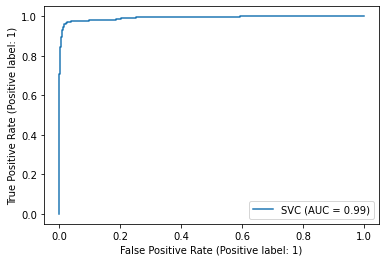

In [210]:
metrics.plot_roc_curve(svm, testX, testy)  
pyplot.show() 

In [90]:
summary={'AUC':round(svm_auc,3), 'AP':round(svm_ap,3),'Precision@100':round(svm_precisionat100,3) ,'Precision@500':round(svm_precisionat500,3),'Precision@1000':round(svm_precisionat1000,3)}
idx=['SVM']
SVM_df=pd.DataFrame(summary, index=idx)
SVM_df

,AUC,AP,Precision@100,Precision@500,Precision@1000
SVM,0.99,0.96,1.0,0.942,0.97


In [211]:
# define model
rfm =RandomForestClassifier(n_estimators=100)

# fit model
rfm.fit(trainX.to_numpy(), trainy.to_numpy())

# predict on test set
predictions = rfm.predict(testX.to_numpy())

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
rfm_score =rfm.predict_proba(testX.to_numpy())[:, 1]
rfm_auc=roc_auc_score(testy.to_numpy(), rfm_score)
rfm_precisionat100=precision_score(testy.to_numpy(), rfm_score, k=100)
rfm_precisionat500=precision_score(testy.to_numpy(), rfm_score, k=500)
rfm_precisionat1000=precision_score(testy.to_numpy(), rfm_score, k=1000)
rfm_ap=average_precision_score(testy.to_numpy(), rfm_score)

# evaluate predictions

print(confusion_matrix(testy.to_numpy(),predictions))
print(classification_report(testy.to_numpy(),predictions))
print(accuracy_score(testy.to_numpy(), predictions))

[[7969   11]
 [  46  492]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7980
           1       0.98      0.91      0.95       538

    accuracy                           0.99      8518
   macro avg       0.99      0.96      0.97      8518
weighted avg       0.99      0.99      0.99      8518

0.993308288330594


In [212]:
summary_rfm={'AUC':round(rfm_auc,3), 'AP':round(rfm_ap,3),'Precision@100':round(rfm_precisionat100,3) ,'Precision@500':round(rfm_precisionat500,3),'Precision@1000':round(rfm_precisionat1000,3)}
idx=['RFM']
RFM_df=pd.DataFrame(summary_rfm, index=idx)
RFM_df

,AUC,AP,Precision@100,Precision@500,Precision@1000
RFM,0.998,0.984,1.0,0.982,0.991


In [213]:
# define model
lr =LogisticRegression(solver='liblinear', random_state=0)

# fit model
lr.fit(trainX.to_numpy(), trainy.to_numpy())

# predict on test set
predictions = lr.predict(testX.to_numpy())

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
lr_score =lr.predict_proba(testX.to_numpy())[:, 1]
lr_auc=roc_auc_score(testy.to_numpy(), lr_score)
lr_precisionat100=precision_score(testy.to_numpy(), lr_score, k=100)
lr_precisionat500=precision_score(testy.to_numpy(), lr_score, k=500)
lr_precisionat1000=precision_score(testy.to_numpy(), lr_score, k=1000)
lr_ap=average_precision_score(testy.to_numpy(), lr_score)

# evaluate predictions

print(confusion_matrix(testy.to_numpy(),predictions))
print(classification_report(testy.to_numpy(),predictions))
print(accuracy_score(testy.to_numpy(), predictions))

[[7896   84]
 [ 167  371]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7980
           1       0.82      0.69      0.75       538

    accuracy                           0.97      8518
   macro avg       0.90      0.84      0.87      8518
weighted avg       0.97      0.97      0.97      8518

0.9705329889645457


In [214]:
summary_lr={'AUC':round(lr_auc,3), 'AP':round(lr_ap,3),'Precision@100':round(lr_precisionat100,3) ,'Precision@500':round(lr_precisionat500,3),'Precision@1000':round(lr_precisionat1000,3)}
idx=['LRM']
LR_df=pd.DataFrame(summary_lr, index=idx)
LR_df

,AUC,AP,Precision@100,Precision@500,Precision@1000
LRM,0.965,0.836,1.0,0.802,0.914


In [215]:
knn = KNeighborsClassifier(n_neighbors=10)

# fit model
knn.fit(trainX.to_numpy(), trainy)

# predict on test set
predictions = knn.predict(testX)

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
knn_score =knn.predict_proba(testX.to_numpy())[:, 1]
knn_auc=roc_auc_score(testy.to_numpy(), knn_score)
knn_precisionat100=precision_score(testy.to_numpy(), knn_score, k=100)
knn_precisionat500=precision_score(testy.to_numpy(), knn_score, k=500)
knn_precisionat1000=precision_score(testy.to_numpy(), knn_score, k=1000)
knn_ap=average_precision_score(testy.to_numpy(), knn_score)

# evaluate predictions

print(confusion_matrix(testy.to_numpy(),predictions))
print(classification_report(testy.to_numpy(),predictions))
print(accuracy_score(testy.to_numpy(), predictions))


[[7950   30]
 [ 186  352]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7980
           1       0.92      0.65      0.77       538

    accuracy                           0.97      8518
   macro avg       0.95      0.83      0.88      8518
weighted avg       0.97      0.97      0.97      8518

0.9746419347264617


In [216]:
summary_knn={'AUC':round(knn_auc,3), 'AP':round(knn_ap,3),'Precision@100':round(knn_precisionat100,3) ,'Precision@500':round(knn_precisionat500,3),'Precision@1000':round(knn_precisionat1000,3)}
idx=['KNN']
KNN_df=pd.DataFrame(summary_knn, index=idx)
KNN_df

,AUC,AP,Precision@100,Precision@500,Precision@1000
KNN,0.954,0.853,1.0,0.84,0.92


In [97]:

idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df=pd.concat([SVM_df,LR_df,RFM_df,KNN_df],axis=0)
AUC_df

,AUC,AP,Precision@100,Precision@500,Precision@1000
SVM,0.990,0.960,1.0,0.942,0.970
LRM,0.964,0.854,1.0,0.812,0.909
RFM,0.995,0.982,1.0,0.976,0.991
KNN,0.956,0.866,1.0,0.864,0.922


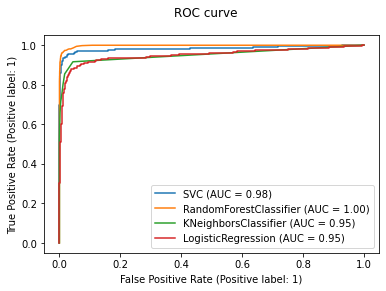

In [77]:
svm_plot = plot_roc_curve(svm, testX.to_numpy(), testy.to_numpy())
rfm_plot = plot_roc_curve(rfm, testX.to_numpy(), testy.to_numpy(), ax=svm_plot.ax_)
knn_plot= plot_roc_curve(knn, testX.to_numpy(), testy.to_numpy(),ax=rfm_plot.ax_)
lr_plot = plot_roc_curve(lr, testX.to_numpy(), testy.to_numpy(), ax=knn_plot.ax_)
lr_plot.figure_.suptitle("ROC curve")

pyplot.show()

In [98]:
features1=['tx_Amount','tx_During_Weekend','tx_During_Night','customer_Id_Nb_Tx_1Day_Window','customer_Id_Avg_Amount_1day_Window','customer_Id_Nb_Tx_7Day_Window','customer_Id_Avg_Amount_7Day_Window','customer_Id_Nb_Tx_30Day_Window','customer_Id_Avg_Amount_30Day_Window','terminal_Id_Nb_Tx_1Day_Window','terminal_Id_Risk_1Day_Window','terminal_Id_Nb_Tx_7Day_Window','terminal_Id_Risk_7Day_Window','terminal_Id_Nb_Tx_30Day_Window','terminal_Id_Risk_30Day_Window']


In [104]:
# define model
svm =SVC()

# fit the model
svm.fit(trainX[features1].to_numpy(), trainy.to_numpy())

# predict on test set
predictions = svm.predict(testX[features1].to_numpy())

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
svm_score_1 =svm.decision_function(testX[features1].to_numpy())
svm_auc_1=roc_auc_score(testy.to_numpy(), svm_score_1)
svm_precisionat100_1=precision_score(testy.to_numpy(), svm_score_1, k=100)
svm_precisionat500_1=precision_score(testy.to_numpy(), svm_score_1, k=500)
svm_precisionat1000_1=precision_score(testy.to_numpy(), svm_score_1, k=1000)
svm_ap_1=average_precision_score(testy.to_numpy(), svm_score_1)

# evaluate predictions
print(confusion_matrix(testy.to_numpy(),predictions))
print(classification_report(testy.to_numpy(),predictions))
print(accuracy_score(testy.to_numpy(), predictions))

[[7954   26]
 [ 266  272]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      7980
           1       0.91      0.51      0.65       538

    accuracy                           0.97      8518
   macro avg       0.94      0.75      0.82      8518
weighted avg       0.96      0.97      0.96      8518

0.965719652500587


In [105]:
summary={'AUC':round(svm_auc_1,3), 'AP':round(svm_ap_1,3),'Precision@100':round(svm_precisionat100_1,3) ,'Precision@500':round(svm_precisionat500_1,3),'Precision@1000':round(svm_precisionat1000_1,3)}
idx=['SVM']
SVM_df_1=pd.DataFrame(summary, index=idx)
SVM_df_1

,AUC,AP,Precision@100,Precision@500,Precision@1000
SVM,0.851,0.69,0.98,0.692,0.719


In [107]:
# define model
rfm =RandomForestClassifier(n_estimators=100)

# fit model
rfm.fit(trainX[features1].to_numpy(), trainy.to_numpy())

# predict on test set
predictions = rfm.predict(testX[features1].to_numpy())

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
rfm_score_1 =rfm.predict_proba(testX[features1].to_numpy())[:, 1]
rfm_auc_1=roc_auc_score(testy.to_numpy(), rfm_score_1)
rfm_precisionat100_1=precision_score(testy.to_numpy(), rfm_score_1, k=100)
rfm_precisionat500_1=precision_score(testy.to_numpy(), rfm_score_1, k=500)
rfm_precisionat1000_1=precision_score(testy.to_numpy(), rfm_score_1, k=1000)
rfm_ap_1=average_precision_score(testy.to_numpy(), rfm_score_1)

# evaluate predictions

print(confusion_matrix(testy.to_numpy(),predictions))
print(classification_report(testy.to_numpy(),predictions))
print(accuracy_score(testy.to_numpy(), predictions))

[[7959   21]
 [ 226  312]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      7980
           1       0.94      0.58      0.72       538

    accuracy                           0.97      8518
   macro avg       0.95      0.79      0.85      8518
weighted avg       0.97      0.97      0.97      8518

0.9710025827659075


In [108]:
summary_rfm={'AUC':round(rfm_auc_1,3), 'AP':round(rfm_ap_1,3),'Precision@100':round(rfm_precisionat100_1,3) ,'Precision@500':round(rfm_precisionat500_1,3),'Precision@1000':round(rfm_precisionat1000_1,3)}
idx=['RFM']
RFM_df_1=pd.DataFrame(summary_rfm, index=idx)
RFM_df_1

,AUC,AP,Precision@100,Precision@500,Precision@1000
RFM,0.905,0.753,1.0,0.726,0.79


In [109]:
# define model
lr =LogisticRegression(solver='liblinear', random_state=0)

# fit model
lr.fit(trainX[features1].to_numpy(), trainy.to_numpy())

# predict on test set
predictions = lr.predict(testX[features1].to_numpy())

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
lr_score_1 =lr.predict_proba(testX[features1].to_numpy())[:, 1]
lr_auc_1=roc_auc_score(testy.to_numpy(), lr_score_1)
lr_precisionat100_1=precision_score(testy.to_numpy(), lr_score_1, k=100)
lr_precisionat500_1=precision_score(testy.to_numpy(), lr_score_1, k=500)
lr_precisionat1000_1=precision_score(testy.to_numpy(), lr_score_1, k=1000)
lr_ap_1=average_precision_score(testy.to_numpy(), lr_score_1)

# evaluate predictions

print(confusion_matrix(testy.to_numpy(),predictions))
print(classification_report(testy.to_numpy(),predictions))
print(accuracy_score(testy.to_numpy(), predictions))

[[7937   43]
 [ 289  249]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7980
           1       0.85      0.46      0.60       538

    accuracy                           0.96      8518
   macro avg       0.91      0.73      0.79      8518
weighted avg       0.96      0.96      0.96      8518

0.9610237144869688


In [110]:
summary_lr={'AUC':round(lr_auc_1,3), 'AP':round(lr_ap_1,3),'Precision@100':round(lr_precisionat100_1,3) ,'Precision@500':round(lr_precisionat500_1,3),'Precision@1000':round(lr_precisionat1000_1,3)}
idx=['LRM']
LR_df_1=pd.DataFrame(summary_lr, index=idx)
LR_df_1

,AUC,AP,Precision@100,Precision@500,Precision@1000
LRM,0.841,0.64,0.98,0.656,0.682


In [113]:
knn = KNeighborsClassifier(n_neighbors=10)

# fit model
knn.fit(trainX[features1].to_numpy(), trainy.to_numpy())

# predict on test set
predictions = knn.predict(testX[features1].to_numpy())

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
knn_score_1 =knn.predict_proba(testX[features1].to_numpy())[:, 1]
knn_auc_1=roc_auc_score(testy.to_numpy(), knn_score_1)
knn_precisionat100_1=precision_score(testy.to_numpy(), knn_score_1, k=100)
knn_precisionat500_1=precision_score(testy.to_numpy(), knn_score_1, k=500)
knn_precisionat1000_1=precision_score(testy.to_numpy(),knn_score_1, k=1000)
knn_ap_1=average_precision_score(testy.to_numpy(), knn_score)

# evaluate predictions

print(confusion_matrix(testy.to_numpy(),predictions))
print(classification_report(testy.to_numpy(),predictions))
print(accuracy_score(testy.to_numpy(), predictions))

[[7949   31]
 [ 303  235]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7980
           1       0.88      0.44      0.58       538

    accuracy                           0.96      8518
   macro avg       0.92      0.72      0.78      8518
weighted avg       0.96      0.96      0.95      8518

0.9607889175862878


In [114]:
summary_knn={'AUC':round(knn_auc_1,3), 'AP':round(knn_ap_1,3),'Precision@100':round(knn_precisionat100_1,3) ,'Precision@500':round(knn_precisionat500_1,3),'Precision@1000':round(knn_precisionat1000_1,3)}
idx=['KNN']
KNN_df_1=pd.DataFrame(summary_knn, index=idx)
KNN_df_1

,AUC,AP,Precision@100,Precision@500,Precision@1000
KNN,0.825,0.866,0.98,0.634,0.638


In [115]:
idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df_1=pd.concat([SVM_df_1,LR_df_1,RFM_df_1,KNN_df_1],axis=0)
AUC_df_1

,AUC,AP,Precision@100,Precision@500,Precision@1000
SVM,0.851,0.690,0.98,0.692,0.719
LRM,0.841,0.640,0.98,0.656,0.682
RFM,0.905,0.753,1.00,0.726,0.790
KNN,0.825,0.866,0.98,0.634,0.638


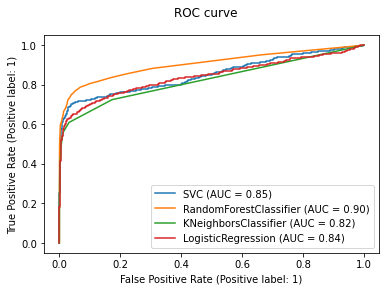

In [116]:
svm_plot = plot_roc_curve(svm, testX[features1].to_numpy(), testy.to_numpy())
rfm_plot = plot_roc_curve(rfm, testX[features1].to_numpy(), testy.to_numpy(), ax=svm_plot.ax_)
knn_plot= plot_roc_curve(knn, testX[features1].to_numpy(), testy.to_numpy(),ax=rfm_plot.ax_)
lr_plot = plot_roc_curve(lr, testX[features1].to_numpy(), testy.to_numpy(), ax=knn_plot.ax_)
lr_plot.figure_.suptitle("ROC curve")

pyplot.show()

## Evaluation of the two models on unseen data

 In that section, we evaluate the approch with the network variables and the one without the network variables on unseen data. To do that we decide to use the cross-validation.

### 1- Evaluation of the performance with the network variables

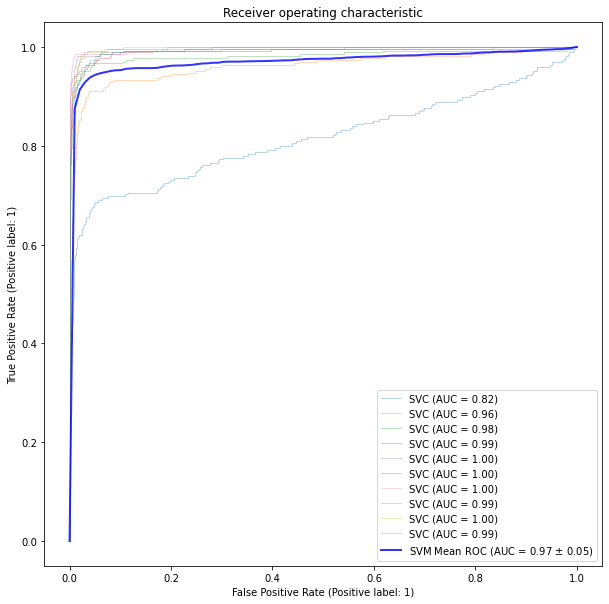

In [127]:
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)

svm =SVC()


tprs_svm = []
aucs_svm = []

svm_AP=[]

svm_Pat100=[]
svm_Pat500=[]
svm_Pat1000=[]

mean_fpr_svm = np.linspace(0, 1, 100)

fig, ax = pyplot.subplots()

for i, (train, test) in enumerate(cv.split(X[features], X['Label'])):
    scaler.fit(X[features])
    data = scaler.transform(X[features])
    
    svm.fit(data[train], X['Label'].iloc[train])

    viz_svm = plot_roc_curve(svm, data[test], X['Label'].iloc[test],
                         alpha=0.3, lw=1, ax=ax)
    
    svm_precision_score= svm.decision_function(data[test])

   
    interp_tpr_svm = np.interp(mean_fpr_svm, viz_svm.fpr, viz_svm.tpr)
   
    interp_tpr_svm[0] = 0.0

    tprs_svm.append(interp_tpr_svm)

    aucs_svm.append(viz_svm.roc_auc)
    
    svm_AP.append(average_precision_score(X['Label'].iloc[test], svm_precision_score))
    
    svm_Pat100.append(precision_score(X['Label'].iloc[test],svm_precision_score, k=100))
    
    svm_Pat500.append(precision_score(X['Label'].iloc[test],svm_precision_score, k=500))
    
    svm_Pat1000.append(precision_score(X['Label'].iloc[test],svm_precision_score, k=1000))



mean_tpr_svm = np.mean(tprs_svm, axis=0)

mean_tpr_svm[-1] = 1.0

mean_auc_svm = auc(mean_fpr_svm, mean_tpr_svm)

std_auc_svm = np.std(aucs_svm)

mean_svm_AP = np.mean(svm_AP)

mean_svm_Pat100 = np.mean(svm_Pat100)

mean_svm_Pat500= np.mean(svm_Pat500)

mean_svm_Pat1000 = np.mean(svm_Pat1000)

std_svm_AP = np.std(svm_AP)

std_svm_Pat100 = np.std(svm_Pat100)

std_svm_Pat500= np.std(svm_Pat500)

std_svm_Pat1000 = np.std(svm_Pat1000)

ax.plot(mean_fpr_svm, mean_tpr_svm, color='b',
        label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svm, std_auc_svm),
        lw=2, alpha=.8)



std_tpr_svm = np.std(tprs_svm, axis=0)

tprs_upper_svm = np.minimum(mean_tpr_svm + std_tpr_svm, 1)

tprs_lower_svm = np.maximum(mean_tpr_svm - std_tpr_svm, 0)

ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")

pyplot.show()

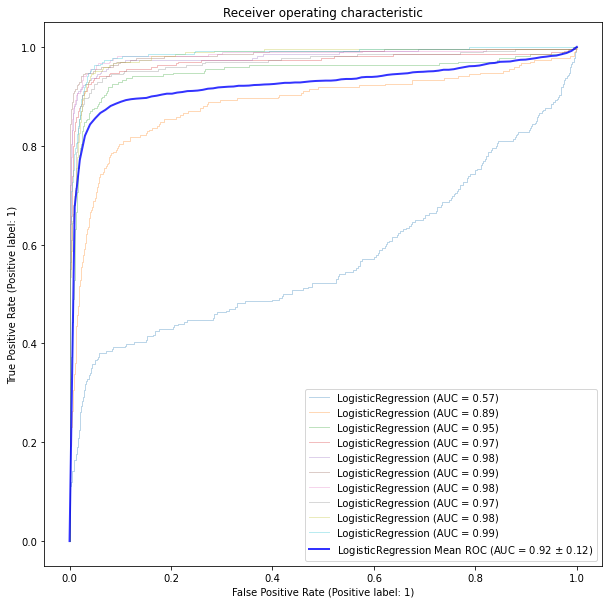

In [128]:
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)


lr =LogisticRegression(solver='liblinear', random_state=0)


tprs_lr = []
aucs_lr = []

mean_fpr_lr = np.linspace(0, 1, 100)

lr_AP=[]

lr_Pat100=[]
lr_Pat500=[]
lr_Pat1000=[]

fig, ax = pyplot.subplots()
for i, (train, test) in enumerate(cv.split(X[features], X['Label'])):
    
    scaler = StandardScaler()
    scaler.fit(X[features])
    data = scaler.transform(X[features])

    lr.fit(data[train], X['Label'].iloc[train])


    viz_lr = plot_roc_curve(lr, data[test], X['Label'].iloc[test],
                         alpha=0.3, lw=1, ax=ax)

    interp_tpr_lr = np.interp(mean_fpr_lr, viz_lr.fpr, viz_lr.tpr)

    interp_tpr_lr[0] = 0.0
    
    tprs_lr.append(interp_tpr_lr)
   
    aucs_lr.append(viz_lr.roc_auc)
    
    lr_precision_score= lr.decision_function(data[test])
    
    lr_AP.append(average_precision_score(X['Label'].iloc[test], lr_precision_score))
    
    lr_Pat100.append(precision_score(X['Label'].iloc[test],lr_precision_score, k=100))
    
    lr_Pat500.append(precision_score(X['Label'].iloc[test],lr_precision_score, k=500))
    
    lr_Pat1000.append(precision_score(X['Label'].iloc[test],lr_precision_score, k=1000))


mean_tpr_lr = np.mean(tprs_lr, axis=0)

mean_tpr_lr[-1] = 1.0

mean_auc_lr = auc(mean_fpr_lr, mean_tpr_lr)

std_auc_lr = np.std(aucs_lr)

mean_lr_AP = np.mean(lr_AP)

mean_lr_Pat100 = np.mean(lr_Pat100)

mean_lr_Pat500= np.mean(lr_Pat500)

mean_lr_Pat1000 = np.mean(lr_Pat1000)

std_lr_AP = np.std(lr_AP)

std_lr_Pat100 = np.std(lr_Pat100)

std_lr_Pat500= np.std(lr_Pat500)

std_lr_Pat1000 = np.std(lr_Pat1000)

ax.plot(mean_fpr_lr, mean_tpr_lr, color='b',
        label=r'LogisticRegression Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lr, std_auc_lr),
        lw=2, alpha=.8)


std_tpr_lr = np.std(tprs_lr, axis=0)

tprs_upper_lr = np.minimum(mean_tpr_lr + std_tpr_lr, 1)

tprs_lower_lr = np.maximum(mean_tpr_lr - std_tpr_lr, 0)


ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
pyplot.show()

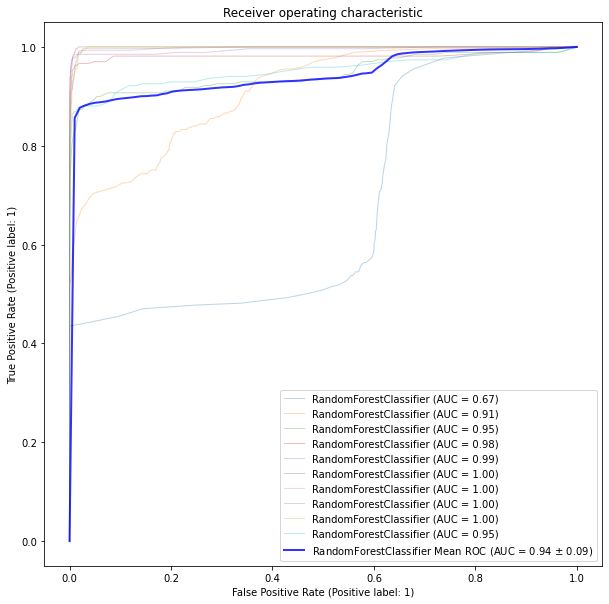

In [129]:
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)

rfm =RandomForestClassifier(n_estimators=100)



tprs_rfm = []
aucs_rfm = []

rfm_AP=[]

rfm_Pat100=[]
rfm_Pat500=[]
rfm_Pat1000=[]
mean_fpr_rfm = np.linspace(0, 1, 100)

fig, ax = pyplot.subplots()
for i, (train, test) in enumerate(cv.split(X[features], X['Label'])):
    

    scaler.fit(X[features])
    data = scaler.transform(X[features])

    rfm.fit(data[train], X['Label'].iloc[train])

    viz_rfm = plot_roc_curve(rfm, data[test], X['Label'].iloc[test],
                         alpha=0.3, lw=1, ax=ax)

    interp_tpr_rfm = np.interp(mean_fpr_rfm, viz_rfm.fpr, viz_rfm.tpr)

    interp_tpr_rfm[0] = 0.0

    tprs_rfm.append(interp_tpr_rfm)

    aucs_rfm.append(viz_rfm.roc_auc)
    
    rfm_precision_score= rfm.predict_proba(data[test])[:, 1]
    
    rfm_AP.append(average_precision_score(X['Label'].iloc[test], rfm_precision_score))
    
    rfm_Pat100.append(precision_score(X['Label'].iloc[test],rfm_precision_score, k=100))
    
    rfm_Pat500.append(precision_score(X['Label'].iloc[test],rfm_precision_score, k=500))
    
    rfm_Pat1000.append(precision_score(X['Label'].iloc[test],rfm_precision_score, k=1000))



mean_tpr_rfm = np.mean(tprs_rfm, axis=0)

mean_tpr_rfm[-1] = 1.0

mean_auc_rfm = auc(mean_fpr_rfm, mean_tpr_rfm)

std_auc_rfm = np.std(aucs_rfm)

mean_rfm_AP = np.mean(rfm_AP)

mean_rfm_Pat100 = np.mean(rfm_Pat100)

mean_rfm_Pat500= np.mean(rfm_Pat500)

mean_rfm_Pat1000 = np.mean(rfm_Pat1000)

std_rfm_AP = np.std(rfm_AP)

std_rfm_Pat100 = np.std(rfm_Pat100)

std_rfm_Pat500= np.std(rfm_Pat500)

std_rfm_Pat1000 = np.std(rfm_Pat1000)


ax.plot(mean_fpr_rfm, mean_tpr_rfm, color='b',
        label=r'RandomForestClassifier Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rfm, std_auc_rfm),
        lw=2, alpha=.8)


std_tpr_rfm = np.std(tprs_rfm, axis=0)

tprs_upper_rfm = np.minimum(mean_tpr_rfm + std_tpr_rfm, 1)


tprs_lower_rfm = np.maximum(mean_tpr_rfm - std_tpr_rfm, 0)


ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
pyplot.show()

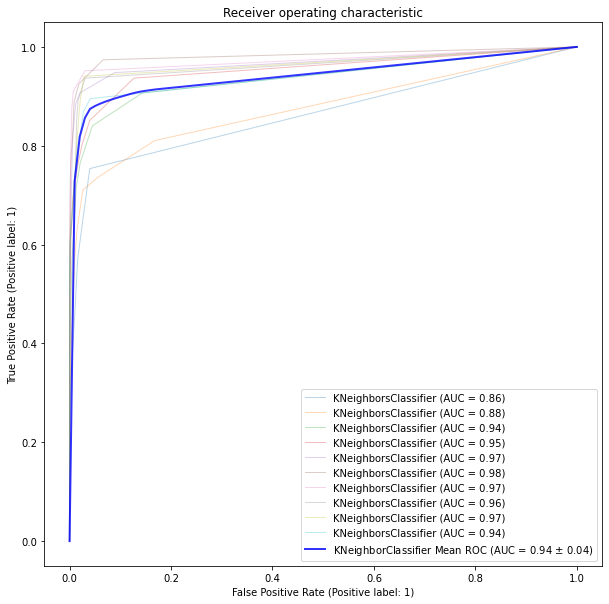

In [130]:
# Classification and ROC analysis
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)


knn = KNeighborsClassifier(n_neighbors=10)


tprs_knn = []
aucs_knn = []

knn_AP=[]

knn_Pat100=[]
knn_Pat500=[]
knn_Pat1000=[]

mean_fpr_knn = np.linspace(0, 1, 100)
fig, ax = pyplot.subplots()
for i, (train, test) in enumerate(cv.split(X[features], X['Label'])):
    scaler.fit(X[features])
    data = scaler.transform(X[features])

    knn.fit(data[train], X['Label'].iloc[train])

    viz_knn = plot_roc_curve(knn, data[test], X['Label'].iloc[test],
                         alpha=0.3, lw=1, ax=ax)
    

    interp_tpr_knn = np.interp(mean_fpr_knn, viz_knn.fpr, viz_knn.tpr)

    interp_tpr_knn[0] = 0.0

    tprs_knn.append(interp_tpr_knn)

    aucs_knn.append(viz_knn.roc_auc)
    
    knn_precision_score= knn.predict_proba(data[test])[:, 1]
    
    knn_AP.append(average_precision_score(X['Label'].iloc[test], knn_precision_score))
    
    knn_Pat100.append(precision_score(X['Label'].iloc[test],knn_precision_score, k=100))
    
    knn_Pat500.append(precision_score(X['Label'].iloc[test],knn_precision_score, k=500))
    
    knn_Pat1000.append(precision_score(X['Label'].iloc[test],knn_precision_score, k=1000))




mean_tpr_knn = np.mean(tprs_knn, axis=0)

mean_tpr_knn[-1] = 1.0

mean_auc_knn = auc(mean_fpr_knn, mean_tpr_knn)

std_auc_knn = np.std(aucs_knn)

mean_knn_AP = np.mean(knn_AP)

mean_knn_Pat100 = np.mean(knn_Pat100)

mean_knn_Pat500= np.mean(knn_Pat500)

mean_knn_Pat1000 = np.mean(knn_Pat1000)

std_knn_AP = np.std(knn_AP)

std_knn_Pat100 = np.std(knn_Pat100)

std_knn_Pat500= np.std(knn_Pat500)

std_knn_Pat1000 = np.std(knn_Pat1000)

ax.plot(mean_fpr_knn, mean_tpr_knn, color='b',
        label=r'KNeighborClassifier Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_knn, std_auc_knn),
        lw=2, alpha=.8)


std_tpr_knn = np.std(tprs_knn, axis=0)

tprs_upper_knn = np.minimum(mean_tpr_knn + std_tpr_knn, 1)

tprs_lower_knn = np.maximum(mean_tpr_knn - std_tpr_knn, 0)


ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
pyplot.show()

### 2- Evaluation without the variables

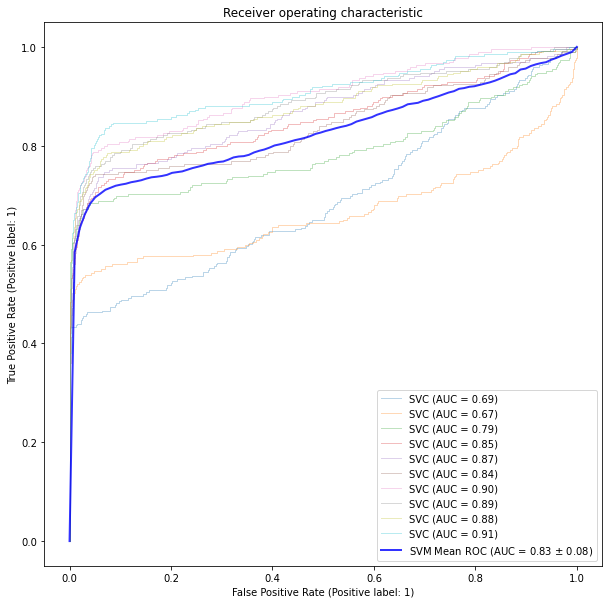

In [132]:
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)

svm =SVC()


tprs_svm_1 = []
aucs_svm_1 = []

svm_AP_1=[]

svm_Pat100_1=[]
svm_Pat500_1=[]
svm_Pat1000_1=[]

mean_fpr_svm_1 = np.linspace(0, 1, 100)

fig, ax = pyplot.subplots()

for i, (train, test) in enumerate(cv.split(X[features1], X['Label'])):
    scaler = StandardScaler()
    scaler.fit(X[features1])
    data = scaler.transform(X[features1])
    
    svm.fit(data[train], X['Label'].iloc[train])

    viz_svm = plot_roc_curve(svm, data[test], X['Label'].iloc[test],
                         alpha=0.3, lw=1, ax=ax)

    
    interp_tpr_svm = np.interp(mean_fpr_svm_1, viz_svm.fpr, viz_svm.tpr)
   
    interp_tpr_svm[0] = 0.0

    tprs_svm_1.append(interp_tpr_svm)

    aucs_svm_1.append(viz_svm.roc_auc)
    
    svm_precision_score= svm.decision_function(data[test])
    
    svm_AP_1.append(average_precision_score(X['Label'].iloc[test], svm_precision_score))
    
    svm_Pat100_1.append(precision_score(X['Label'].iloc[test],svm_precision_score, k=100))
    
    svm_Pat500_1.append(precision_score(X['Label'].iloc[test],svm_precision_score, k=500))
    
    svm_Pat1000_1.append(precision_score(X['Label'].iloc[test],svm_precision_score, k=1000))




mean_tpr_svm_1 = np.mean(tprs_svm_1, axis=0)

mean_tpr_svm_1[-1] = 1.0

mean_auc_svm_1 = auc(mean_fpr_svm_1, mean_tpr_svm_1)

std_auc_svm_1 = np.std(aucs_svm_1)

mean_svm_AP_1 = np.mean(svm_AP_1)

mean_svm_Pat100_1 = np.mean(svm_Pat100_1)

mean_svm_Pat500_1= np.mean(svm_Pat500_1)

mean_svm_Pat1000_1 = np.mean(svm_Pat1000_1)

std_svm_AP_1 = np.std(svm_AP_1)

std_svm_Pat100_1 = np.std(svm_Pat100_1)

std_svm_Pat500_1= np.std(svm_Pat500_1)

std_svm_Pat1000_1 = np.std(svm_Pat1000_1)

ax.plot(mean_fpr_svm_1, mean_tpr_svm_1, color='b',
        label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svm_1, std_auc_svm_1),
        lw=2, alpha=.8)



std_tpr_svm_1 = np.std(tprs_svm_1, axis=0)

tprs_upper_svm_1 = np.minimum(mean_tpr_svm_1 + std_tpr_svm_1, 1)

tprs_lower_svm_1 = np.maximum(mean_tpr_svm_1 - std_tpr_svm_1, 0)

ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")

pyplot.show()

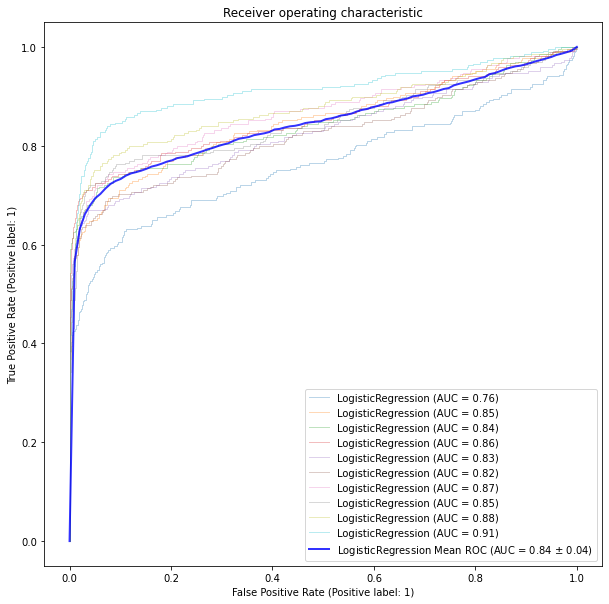

In [134]:
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)


lr =LogisticRegression(solver='liblinear', random_state=0)


tprs_lr_1 = []
aucs_lr_1 = []

lr_AP_1=[]

lr_Pat100_1=[]
lr_Pat500_1=[]
lr_Pat1000_1=[]

mean_fpr_lr_1 = np.linspace(0, 1, 100)

fig, ax = pyplot.subplots()
for i, (train, test) in enumerate(cv.split(X[features1], X['Label'])):
    
    scaler = StandardScaler()
    scaler.fit(X[features1])
    data = scaler.transform(X[features1])

    lr.fit(data[train], X['Label'].iloc[train])


    viz_lr = plot_roc_curve(lr, data[test], X['Label'].iloc[test],
                         alpha=0.3, lw=1, ax=ax)

    interp_tpr_lr = np.interp(mean_fpr_lr_1, viz_lr.fpr, viz_lr.tpr)

    interp_tpr_lr[0] = 0.0
    
    tprs_lr_1.append(interp_tpr_lr)
   
    aucs_lr_1.append(viz_lr.roc_auc)
    
    lr_precision_score= lr.decision_function(data[test])
    
    lr_AP_1.append(average_precision_score(X['Label'].iloc[test], lr_precision_score))
    
    lr_Pat100_1.append(precision_score(X['Label'].iloc[test],lr_precision_score, k=100))
    
    lr_Pat500_1.append(precision_score(X['Label'].iloc[test],lr_precision_score, k=500))
    
    lr_Pat1000_1.append(precision_score(X['Label'].iloc[test],lr_precision_score, k=1000))
    


mean_tpr_lr_1 = np.mean(tprs_lr_1, axis=0)

mean_tpr_lr_1[-1] = 1.0

mean_auc_lr_1 = auc(mean_fpr_lr_1, mean_tpr_lr_1)

std_auc_lr_1 = np.std(aucs_lr_1)

mean_lr_AP_1 = np.mean(lr_AP_1)

mean_lr_Pat100_1 = np.mean(lr_Pat100_1)

mean_lr_Pat500_1= np.mean(lr_Pat500_1)

mean_lr_Pat1000_1 = np.mean(lr_Pat1000_1)

std_lr_AP_1 = np.std(lr_AP_1)

std_lr_Pat100_1 = np.std(lr_Pat100_1)

std_lr_Pat500_1= np.std(lr_Pat500_1)

std_lr_Pat1000_1 = np.std(lr_Pat1000_1)

ax.plot(mean_fpr_lr_1, mean_tpr_lr_1, color='b',
        label=r'LogisticRegression Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lr_1, std_auc_lr_1),
        lw=2, alpha=.8)


std_tpr_lr_1 = np.std(tprs_lr_1, axis=0)

tprs_upper_lr_1 = np.minimum(mean_tpr_lr_1 + std_tpr_lr_1, 1)

tprs_lower_lr_1 = np.maximum(mean_tpr_lr_1 - std_tpr_lr_1, 0)


ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
pyplot.show()

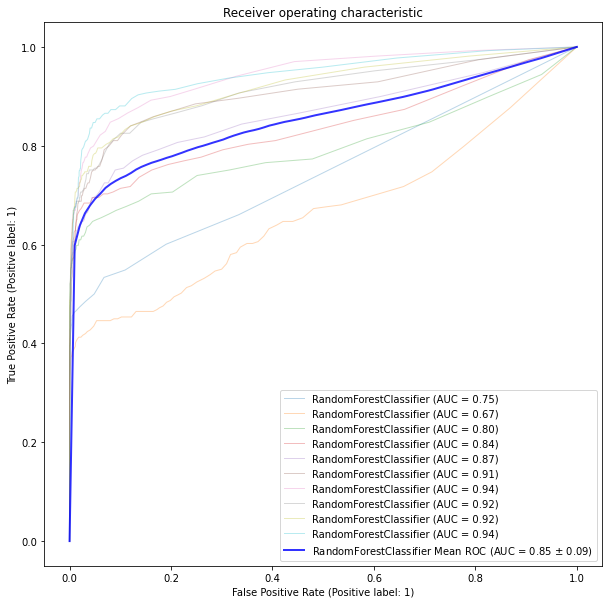

In [135]:
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)

rfm =RandomForestClassifier(n_estimators=100)



tprs_rfm_1 = []
aucs_rfm_1 = []

rfm_AP_1=[]

rfm_Pat100_1=[]
rfm_Pat500_1=[]
rfm_Pat1000_1=[]

mean_fpr_rfm_1 = np.linspace(0, 1, 100)

fig, ax = pyplot.subplots()
for i, (train, test) in enumerate(cv.split(X[features1], X['Label'])):
    
    scaler = StandardScaler()
    scaler.fit(X[features1])
    data = scaler.transform(X[features1])

    rfm.fit(data[train], X['Label'].iloc[train])

    viz_rfm = plot_roc_curve(rfm, data[test], X['Label'].iloc[test],
                         alpha=0.3, lw=1, ax=ax)

    interp_tpr_rfm = np.interp(mean_fpr_rfm_1, viz_rfm.fpr, viz_rfm.tpr)

    interp_tpr_rfm[0] = 0.0

    tprs_rfm_1.append(interp_tpr_rfm)

    aucs_rfm_1.append(viz_rfm.roc_auc)
    
    rfm_precision_score= rfm.predict_proba(data[test])[:, 1]
    
    rfm_AP_1.append(average_precision_score(X['Label'].iloc[test], rfm_precision_score))
    
    rfm_Pat100_1.append(precision_score(X['Label'].iloc[test],rfm_precision_score, k=100))
    
    rfm_Pat500_1.append(precision_score(X['Label'].iloc[test],rfm_precision_score, k=500))
    
    rfm_Pat1000_1.append(precision_score(X['Label'].iloc[test],rfm_precision_score, k=1000))


mean_tpr_rfm_1 = np.mean(tprs_rfm_1, axis=0)

mean_tpr_rfm_1[-1] = 1.0

mean_auc_rfm_1 = auc(mean_fpr_rfm_1, mean_tpr_rfm_1)

std_auc_rfm_1 = np.std(aucs_rfm_1)

mean_rfm_AP_1 = np.mean(rfm_AP_1)

mean_rfm_Pat100_1 = np.mean(rfm_Pat100_1)

mean_rfm_Pat500_1= np.mean(rfm_Pat500_1)

mean_rfm_Pat1000_1 = np.mean(rfm_Pat1000_1)

std_rfm_AP_1 = np.std(rfm_AP_1)

std_rfm_Pat100_1 = np.std(rfm_Pat100_1)

std_rfm_Pat500_1= np.std(rfm_Pat500)

std_rfm_Pat1000_1 = np.std(rfm_Pat1000_1)


ax.plot(mean_fpr_rfm_1, mean_tpr_rfm_1, color='b',
        label=r'RandomForestClassifier Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rfm_1, std_auc_rfm_1),
        lw=2, alpha=.8)


std_tpr_rfm_1 = np.std(tprs_rfm_1, axis=0)

tprs_upper_rfm_1 = np.minimum(mean_tpr_rfm_1 + std_tpr_rfm_1, 1)


tprs_lower_rfm_1 = np.maximum(mean_tpr_rfm_1 - std_tpr_rfm_1, 0)


ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
pyplot.show()

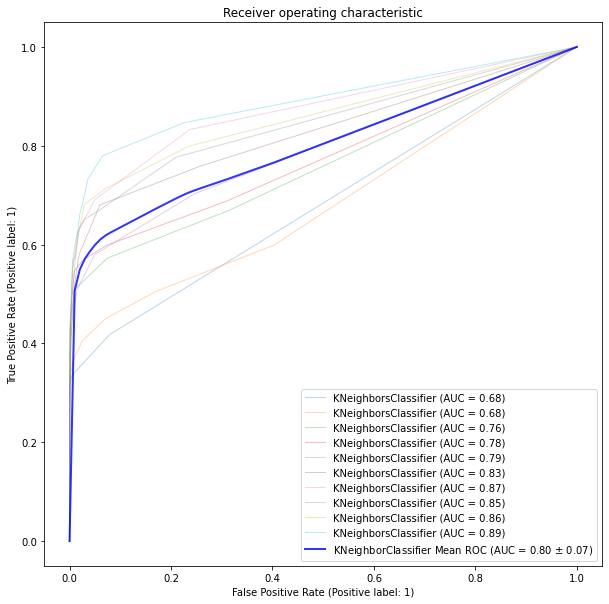

In [137]:
# Classification and ROC analysis
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)


knn = KNeighborsClassifier(n_neighbors=10)


tprs_knn_1 = []
aucs_knn_1 = []

knn_AP_1=[]

knn_Pat100_1=[]
knn_Pat500_1=[]
knn_Pat1000_1=[]

mean_fpr_knn_1 = np.linspace(0, 1, 100)
fig, ax = pyplot.subplots()
for i, (train, test) in enumerate(cv.split(X[features1], X['Label'])):
    scaler = StandardScaler()
    scaler.fit(X[features1])
    data = scaler.transform(X[features1])

    knn.fit(data[train], X['Label'].iloc[train])

    viz_knn = plot_roc_curve(knn, data[test], X['Label'].iloc[test],
                         alpha=0.3, lw=1, ax=ax)
    

    interp_tpr_knn = np.interp(mean_fpr_knn_1, viz_knn.fpr, viz_knn.tpr)

    interp_tpr_knn[0] = 0.0

    tprs_knn_1.append(interp_tpr_knn)

    aucs_knn_1.append(viz_knn.roc_auc)
    
    knn_precision_score= knn.predict_proba(data[test])[:, 1]
    
    knn_AP_1.append(average_precision_score(X['Label'].iloc[test], knn_precision_score))
    
    knn_Pat100_1.append(precision_score(X['Label'].iloc[test],knn_precision_score, k=100))
    
    knn_Pat500_1.append(precision_score(X['Label'].iloc[test],knn_precision_score, k=500))
    
    knn_Pat1000_1.append(precision_score(X['Label'].iloc[test],knn_precision_score, k=1000))




mean_tpr_knn_1 = np.mean(tprs_knn_1, axis=0)

mean_tpr_knn_1[-1] = 1.0

mean_auc_knn_1 = auc(mean_fpr_knn_1, mean_tpr_knn_1)

std_auc_knn_1 = np.std(aucs_knn_1)

mean_knn_AP_1 = np.mean(knn_AP_1)

mean_knn_Pat100_1 = np.mean(knn_Pat100_1)

mean_knn_Pat500_1= np.mean(knn_Pat500_1)

mean_knn_Pat1000_1 = np.mean(knn_Pat1000_1)

std_knn_AP_1 = np.std(knn_AP_1)

std_knn_Pat100_1 = np.std(knn_Pat100_1)

std_knn_Pat500_1= np.std(knn_Pat500_1)

std_knn_Pat1000_1 = np.std(knn_Pat1000_1)


ax.plot(mean_fpr_knn_1, mean_tpr_knn_1, color='b',
        label=r'KNeighborClassifier Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_knn_1, std_auc_knn_1),
        lw=2, alpha=.8)


std_tpr_knn_1 = np.std(tprs_knn_1, axis=0)

tprs_upper_knn_1 = np.minimum(mean_tpr_knn_1 + std_tpr_knn_1, 1)

tprs_lower_knn_1 = np.maximum(mean_tpr_knn_1 - std_tpr_knn_1, 0)


ax.figure.set_figheight(10)
ax.figure.set_figwidth(10)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
pyplot.show()

In [139]:

svm_with_variable=r'%0.2f $\pm$ %0.2f' %(mean_auc_svm, std_auc_svm)
svm_wo_variable=r' %0.2f $\pm$ %0.2f' % (mean_auc_svm_1, std_auc_svm_1)
lr_with_variable=r'%0.2f $\pm$ %0.2f' %(mean_auc_lr, std_auc_lr)
lr_wo_variable=r' %0.2f $\pm$ %0.2f' % (mean_auc_lr_1, std_auc_lr_1)
rfm_with_variable=r'%0.2f $\pm$ %0.2f' %(mean_auc_rfm, std_auc_rfm)
rfm_wo_variable=r' %0.2f $\pm$ %0.2f' % (mean_auc_rfm_1, std_auc_rfm_1)
knn_with_variable=r'%0.2f $\pm$ %0.2f' %(mean_auc_knn, std_auc_knn)
knn_wo_variable=r' %0.2f $\pm$ %0.2f' % (mean_auc_knn_1, std_auc_knn_1)
AUC={'Mean AUC with the network variables':[svm_with_variable,lr_with_variable,rfm_with_variable,knn_with_variable],'Mean AUC without the network variables':[svm_wo_variable,lr_wo_variable,rfm_wo_variable,knn_wo_variable]}
idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df=pd.DataFrame(AUC, index=idx)
AUC_df

,Mean AUC with the network variables,Mean AUC without the network variables
SVM,0.97 $\pm$ 0.05,0.83 $\pm$ 0.08
LogisticRegression,0.92 $\pm$ 0.12,0.84 $\pm$ 0.04
RandomForestClassifier,0.94 $\pm$ 0.09,0.85 $\pm$ 0.09
KNeighborClassifier,0.94 $\pm$ 0.04,0.80 $\pm$ 0.07


In [142]:
svm_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_svm_AP, std_svm_AP)
svm_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_svm_AP_1, std_svm_AP_1)
lr_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_lr_AP, std_lr_AP)
lr_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_lr_AP_1, std_lr_AP_1)
rfm_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_rfm_AP, std_rfm_AP)
rfm_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_rfm_AP_1, std_rfm_AP_1)
knn_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_knn_AP, std_knn_AP)
knn_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_knn_AP_1, std_knn_AP_1)
AP={'Mean AP with the network variables':[svm_with_variable_1,lr_with_variable_1,rfm_with_variable_1,knn_with_variable_1],'Mean AP without the network variables':[svm_wo_variable_1,lr_wo_variable_1,rfm_wo_variable_1,knn_wo_variable_1]}
idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df=pd.DataFrame(AP, index=idx)
AUC_df

,Mean AP with the network variables,Mean AP without the network variables
SVM,0.92 $\pm$ 0.10,0.68 $\pm$ 0.08
LogisticRegression,0.80 $\pm$ 0.20,0.68 $\pm$ 0.05
RandomForestClassifier,0.89 $\pm$ 0.16,0.69 $\pm$ 0.11
KNeighborClassifier,0.82 $\pm$ 0.10,0.57 $\pm$ 0.09


In [153]:
svm_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_svm_Pat100, std_svm_Pat100)
svm_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_svm_Pat100_1, std_svm_Pat100_1)
lr_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_lr_Pat100, std_lr_Pat100)
lr_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_lr_Pat100_1, std_lr_Pat100_1)
rfm_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_rfm_Pat100, std_rfm_Pat100)
rfm_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_rfm_Pat100_1, std_rfm_Pat100_1)
knn_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_knn_Pat100, std_knn_Pat100)
knn_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_knn_Pat100_1, std_knn_Pat100_1)
AP={'Mean Precision@100 with the network variables':[svm_with_variable_1,lr_with_variable_1,rfm_with_variable_1,knn_with_variable_1],'Mean Precision@100 without the network variables':[svm_wo_variable_1,lr_wo_variable_1,rfm_wo_variable_1,knn_wo_variable_1]}
idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df=pd.DataFrame(AP, index=idx)
AUC_df

,Mean Precision@100 with the network variables,Mean Precision@100 without the network variables
SVM,0.98 $\pm$ 0.03,0.97 $\pm$ 0.02
LogisticRegression,0.91 $\pm$ 0.17,0.97 $\pm$ 0.03
RandomForestClassifier,1.00 $\pm$ 0.00,0.98 $\pm$ 0.02
KNeighborClassifier,0.98 $\pm$ 0.03,0.95 $\pm$ 0.03


In [152]:
svm_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_svm_Pat500, std_svm_Pat500)
svm_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_svm_Pat500_1, std_svm_Pat500_1)
lr_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_lr_Pat500, std_lr_Pat500)
lr_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_lr_Pat500_1, std_lr_Pat500_1)
rfm_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_rfm_Pat500, std_rfm_Pat500)
rfm_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_rfm_Pat500_1, std_rfm_Pat500_1)
knn_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_knn_Pat500, std_knn_Pat500)
knn_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_knn_Pat500_1, std_knn_Pat500_1)
AP={'Mean Precision@500 with the network variables':[svm_with_variable_1,lr_with_variable_1,rfm_with_variable_1,knn_with_variable_1],'Mean Precision@500 without the network variables':[svm_wo_variable_1,lr_wo_variable_1,rfm_wo_variable_1,knn_wo_variable_1]}
idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df=pd.DataFrame(AP, index=idx)
AUC_df

,Mean Precision@500 with the network variables,Mean Precision@500 without the network variables
SVM,0.95 $\pm$ 0.09,0.71 $\pm$ 0.10
LogisticRegression,0.87 $\pm$ 0.17,0.72 $\pm$ 0.06
RandomForestClassifier,0.89 $\pm$ 0.17,0.72 $\pm$ 0.17
KNeighborClassifier,0.88 $\pm$ 0.07,0.62 $\pm$ 0.11


In [154]:
svm_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_svm_Pat1000, std_svm_Pat1000)
svm_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_svm_Pat1000_1, std_svm_Pat1000_1)
lr_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_lr_Pat1000, std_lr_Pat1000)
lr_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_lr_Pat1000_1, std_lr_Pat1000_1)
rfm_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_rfm_Pat1000, std_rfm_Pat1000)
rfm_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_rfm_Pat1000_1, std_rfm_Pat1000_1)
knn_with_variable_1=r'%0.2f $\pm$ %0.2f' %(mean_knn_Pat1000, std_knn_Pat1000)
knn_wo_variable_1=r' %0.2f $\pm$ %0.2f' % (mean_knn_Pat1000_1, std_knn_Pat1000_1)
AP={'Mean Precision@1000 with the network variables':[svm_with_variable_1,lr_with_variable_1,rfm_with_variable_1,knn_with_variable_1],'Mean Precision@1000 without the network variables':[svm_wo_variable_1,lr_wo_variable_1,rfm_wo_variable_1,knn_wo_variable_1]}
idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df=pd.DataFrame(AP, index=idx)
AUC_df

,Mean Precision@1000 with the network variables,Mean Precision@1000 without the network variables
SVM,0.96 $\pm$ 0.08,0.74 $\pm$ 0.10
LogisticRegression,0.91 $\pm$ 0.16,0.77 $\pm$ 0.05
RandomForestClassifier,0.91 $\pm$ 0.16,0.78 $\pm$ 0.13
KNeighborClassifier,0.91 $\pm$ 0.07,0.65 $\pm$ 0.12


In [168]:
    
svm_AUC_list=[]
rfm_AUC_list=[]
lr_AUC_list=[]
knn_AUC_list=[]


svm_AP_list=[]
rfm_AP_list=[]
lr_AP_list=[]
knn_AP_list=[]


svm_Pat100_list=[]
rfm_Pat100_list=[]
lr_Pat100_list=[]
knn_Pat100_list=[]

svm_Pat500_list=[]
rfm_Pat500_list=[]
lr_Pat500_list=[]
knn_Pat500_list=[]


svm_Pat1000_list=[]
rfm_Pat1000_list=[]
lr_Pat1000_list=[]
knn_Pat1000_list=[]

    # Performace Analysis of the number of observations
for i in range(10,101,10):
    
    
    # models
    svm =SVC()
    lr =LogisticRegression(solver='liblinear', random_state=0)
    rfm =RandomForestClassifier(n_estimators=100)
    knn = KNeighborsClassifier(n_neighbors=10)
    
    
    # sampling X
    sample = X.sample(frac=i*0.01)
    scaler = StandardScaler()
    scaler.fit(sample[features])
    data = scaler.transform(sample[features])
    
    # splitting the data
    trainX, testX, trainy, testy = train_test_split(data,sample['Label'], test_size = 0.2,stratify=sample['Label'])
    
    
    # fitting the models
    
    svm.fit(trainX, trainy)
    rfm.fit(trainX, trainy)
    lr.fit(trainX, trainy)
    knn.fit(trainX, trainy)
    
    
    # Precision score
    
    svm_precision_score= svm.decision_function(testX)
    lr_precision_score= lr.decision_function(testX)

    
    # ROC AUC score
    svm_AUC = roc_auc_score(testy, svm_precision_score)
    rfm_AUC = roc_auc_score(testy, rfm.predict_proba(testX)[:, 1])
    lr_AUC = roc_auc_score(testy, lr_precision_score)
    knn_AUC = roc_auc_score(testy, knn.predict_proba(testX)[:, 1])
    
    
        # AP score
    svm_AP = average_precision_score(testy, svm_precision_score)
    rfm_AP = average_precision_score(testy, rfm.predict_proba(testX)[:, 1])
    lr_AP = average_precision_score(testy, lr_precision_score)
    knn_AP = average_precision_score(testy, knn.predict_proba(testX)[:, 1])
    
            # Precision@100 score
    svm_Pat100 = precision_score(testy, svm_precision_score, k=100)
    rfm_Pat100 = precision_score(testy, rfm.predict_proba(testX)[:, 1], k=100)
    lr_Pat100 =  precision_score(testy, lr_precision_score,k=100)
    knn_Pat100 = precision_score(testy, knn.predict_proba(testX)[:, 1],  k=100)
    
            # Precision@500 score
    svm_Pat500 = precision_score(testy, svm_precision_score, k=500)
    rfm_Pat500  = precision_score(testy, rfm.predict_proba(testX)[:, 1], k=500)
    lr_Pat500  =  precision_score(testy, lr_precision_score,k=500)
    knn_Pat500  = precision_score(testy, knn.predict_proba(testX)[:, 1],  k=500)  
    

            # Precision@1000 score
    svm_Pat1000 = precision_score(testy, svm_precision_score, k=1000)
    rfm_Pat1000  = precision_score(testy, rfm.predict_proba(testX)[:, 1], k=1000)
    lr_Pat1000  =  precision_score(testy, lr_precision_score,k=1000)
    knn_Pat1000  = precision_score(testy, knn.predict_proba(testX)[:, 1],  k=1000)   
    
    
    # Adding the AUC score into a list for plotting
    svm_AUC_list.append(svm_AUC)
    rfm_AUC_list.append(rfm_AUC)
    lr_AUC_list.append(lr_AUC)
    knn_AUC_list.append(knn_AUC)
    
    
    # Adding the AP score into a list for plotting
    svm_AP_list.append(svm_AP)
    rfm_AP_list.append(rfm_AP)
    lr_AP_list.append(lr_AP)
    knn_AP_list.append(knn_AP)
    
    
    # Adding the Precision@100 score into a list for plotting
    svm_Pat100_list.append(svm_Pat100)
    rfm_Pat100_list.append(rfm_Pat100)
    lr_Pat100_list.append(lr_Pat100)
    knn_Pat100_list.append(knn_Pat100)
    
    
    # Adding the Precision@500 score into a list for plotting
    svm_Pat500_list.append(svm_Pat500)
    rfm_Pat500_list.append(rfm_Pat500)
    lr_Pat500_list.append(lr_Pat500)
    knn_Pat500_list.append(knn_Pat500)
    
    
    
    # Adding the Precision@1000 score into a list for plotting
    svm_Pat1000_list.append(svm_Pat1000)
    rfm_Pat1000_list.append(rfm_Pat1000)
    lr_Pat1000_list.append(lr_Pat1000)
    knn_Pat1000_list.append(knn_Pat1000)
        

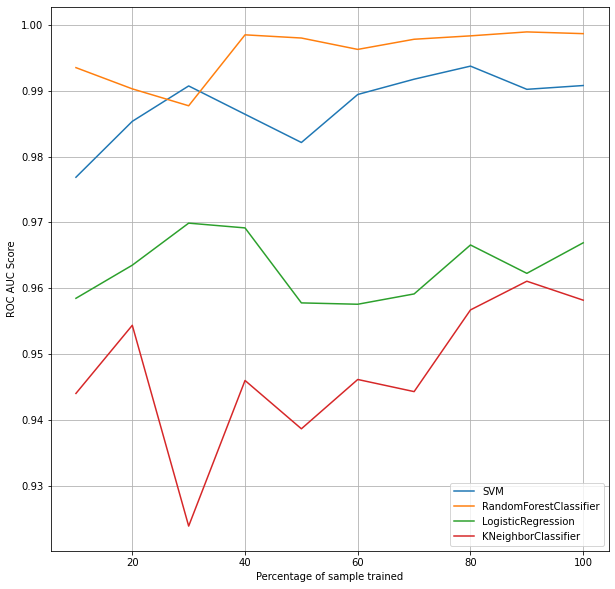

In [169]:
pyplot.figure(figsize=(10,10))
pyplot.plot(range(10,101,10),svm_AUC_list)
pyplot.plot(range(10,101,10),rfm_AUC_list)
pyplot.plot(range(10,101,10),lr_AUC_list)
pyplot.plot(range(10,101,10),knn_AUC_list)
pyplot.legend(["SVM","RandomForestClassifier","LogisticRegression","KNeighborClassifier"],fontsize=10,loc='lower right')
pyplot.grid(True)
pyplot.xticks()
pyplot.yticks()
pyplot.xlabel("Percentage of sample trained")
pyplot.ylabel("ROC AUC Score")
pyplot.show()

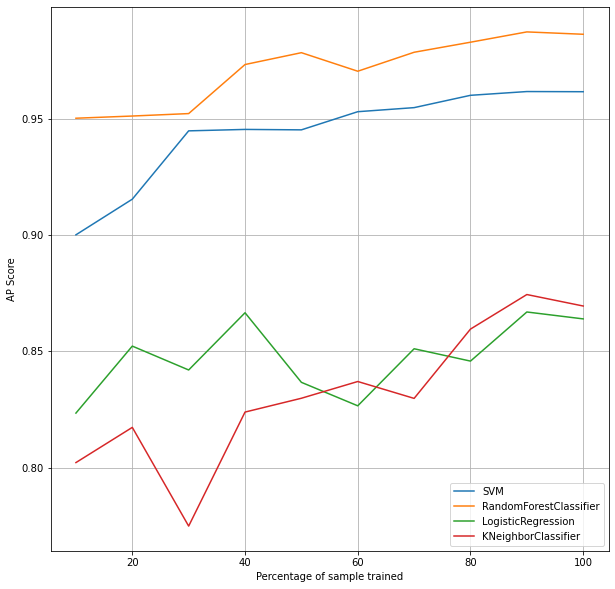

In [170]:
pyplot.figure(figsize=(10,10))
pyplot.plot(range(10,101,10),svm_AP_list)
pyplot.plot(range(10,101,10),rfm_AP_list)
pyplot.plot(range(10,101,10),lr_AP_list)
pyplot.plot(range(10,101,10),knn_AP_list)
pyplot.legend(["SVM","RandomForestClassifier","LogisticRegression","KNeighborClassifier"],fontsize=10,loc='lower right')
pyplot.grid(True)
pyplot.xticks()
pyplot.yticks()
pyplot.xlabel("Percentage of sample trained")
pyplot.ylabel("AP Score")
pyplot.show()

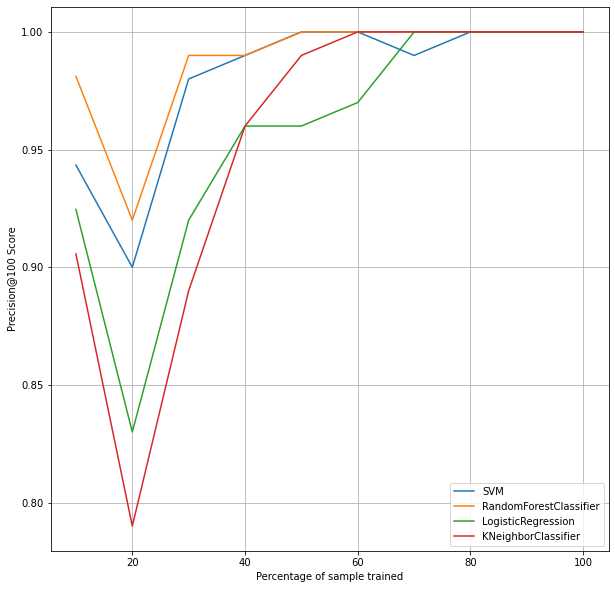

In [171]:
pyplot.figure(figsize=(10,10))
pyplot.plot(range(10,101,10),svm_Pat100_list)
pyplot.plot(range(10,101,10),rfm_Pat100_list)
pyplot.plot(range(10,101,10),lr_Pat100_list)
pyplot.plot(range(10,101,10),knn_Pat100_list)
pyplot.legend(["SVM","RandomForestClassifier","LogisticRegression","KNeighborClassifier"],fontsize=10,loc='lower right')
pyplot.grid(True)
pyplot.xticks()
pyplot.yticks()
pyplot.xlabel("Percentage of sample trained")
pyplot.ylabel("Precision@100 Score")
pyplot.show()

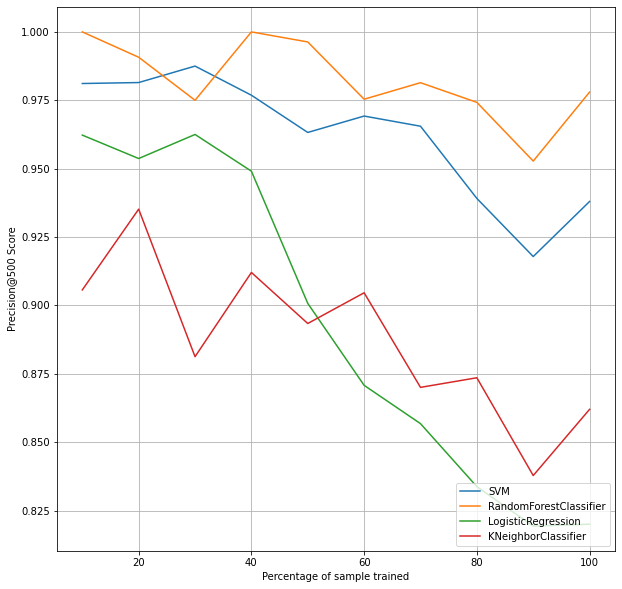

In [172]:
pyplot.figure(figsize=(10,10))
pyplot.plot(range(10,101,10),svm_Pat500_list)
pyplot.plot(range(10,101,10),rfm_Pat500_list)
pyplot.plot(range(10,101,10),lr_Pat500_list)
pyplot.plot(range(10,101,10),knn_Pat500_list)
pyplot.legend(["SVM","RandomForestClassifier","LogisticRegression","KNeighborClassifier"],fontsize=10,loc='lower right')
pyplot.grid(True)
pyplot.xticks()
pyplot.yticks()
pyplot.xlabel("Percentage of sample trained")
pyplot.ylabel("Precision@500 Score")
pyplot.show()

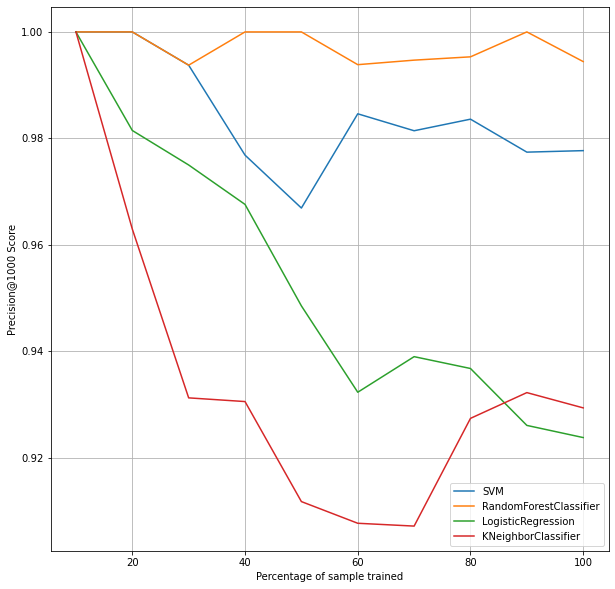

In [174]:
pyplot.figure(figsize=(10,10))
pyplot.plot(range(10,101,10),svm_Pat1000_list)
pyplot.plot(range(10,101,10),rfm_Pat1000_list)
pyplot.plot(range(10,101,10),lr_Pat1000_list)
pyplot.plot(range(10,101,10),knn_Pat1000_list)
pyplot.legend(["SVM","RandomForestClassifier","LogisticRegression","KNeighborClassifier"],fontsize=10,loc='lower right')
pyplot.grid(True)
pyplot.xticks()
pyplot.yticks()
pyplot.xlabel("Percentage of sample trained")
pyplot.ylabel("Precision@1000 Score")
pyplot.show()

### Experiments with one Network variable

#### Experience with the eigenvector variable

In [175]:
features2=['tx_Amount','tx_During_Weekend','tx_During_Night','customer_Id_Nb_Tx_1Day_Window','customer_Id_Avg_Amount_1day_Window','customer_Id_Nb_Tx_7Day_Window','customer_Id_Avg_Amount_7Day_Window','customer_Id_Nb_Tx_30Day_Window','customer_Id_Avg_Amount_30Day_Window','terminal_Id_Nb_Tx_1Day_Window','terminal_Id_Risk_1Day_Window','terminal_Id_Nb_Tx_7Day_Window','terminal_Id_Risk_7Day_Window','terminal_Id_Nb_Tx_30Day_Window','terminal_Id_Risk_30Day_Window','eigenvectorcentrality']

In [184]:
#features
features2=['tx_Amount','tx_During_Weekend','tx_During_Night','customer_Id_Nb_Tx_1Day_Window','customer_Id_Avg_Amount_1day_Window','customer_Id_Nb_Tx_7Day_Window','customer_Id_Avg_Amount_7Day_Window','customer_Id_Nb_Tx_30Day_Window','customer_Id_Avg_Amount_30Day_Window','terminal_Id_Nb_Tx_1Day_Window','terminal_Id_Risk_1Day_Window','terminal_Id_Nb_Tx_7Day_Window','terminal_Id_Risk_7Day_Window','terminal_Id_Nb_Tx_30Day_Window','terminal_Id_Risk_30Day_Window','eigenvectorcentrality']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)

svm =SVC()
lr =LogisticRegression(solver='liblinear', random_state=0)
rfm =RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=10)





svm_AUC_eigcent=[]
lr_AUC_eigcent=[]
rfm_AUC_eigcent=[]
knn_AUC_eigcent=[]

svm_AP_eigcent=[]
lr_AP_eigcent=[]
rfm_AP_eigcent=[]
knn_AP_eigcent=[]

svm_Pat100_eigcent=[]
lr_Pat100_eigcent=[]
rfm_Pat100_eigcent=[]
knn_Pat100_eigcent=[]


svm_Pat500_eigcent=[]
lr_Pat500_eigcent=[]
rfm_Pat500_eigcent=[]
knn_Pat500_eigcent=[]

svm_Pat1000_eigcent=[]
lr_Pat1000_eigcent=[]
rfm_Pat1000_eigcent=[]
knn_Pat1000_eigcent=[]


for i, (train, test) in enumerate(cv.split(X[features2], X['Label'])):
    scaler = StandardScaler()
    scaler.fit(X[features2])
    data = scaler.transform(X[features2])
    
    svm.fit(data[train], X['Label'].iloc[train])
    lr.fit(data[train], X['Label'].iloc[train])
    rfm.fit(data[train], X['Label'].iloc[train])
    knn.fit(data[train], X['Label'].iloc[train])
    
    svm_precision_score= svm.decision_function(data[test])
    lr_precision_score= lr.decision_function(data[test])
    
    
    
    svm_AUC_eigcent.append(roc_auc_score(X['Label'].iloc[test], svm_precision_score))
    lr_AUC_eigcent.append(roc_auc_score(X['Label'].iloc[test], lr_precision_score))
    rfm_AUC_eigcent.append(roc_auc_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1]))
    knn_AUC_eigcent.append(roc_auc_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1]))

    
    svm_AP_eigcent.append(average_precision_score(X['Label'].iloc[test], svm_precision_score))
    lr_AP_eigcent.append(average_precision_score(X['Label'].iloc[test], lr_precision_score))
    rfm_AP_eigcent.append(average_precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1]))
    knn_AP_eigcent.append(average_precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1]))

    
    svm_Pat100_eigcent.append(precision_score(X['Label'].iloc[test], svm_precision_score,k=100))
    lr_Pat100_eigcent.append(precision_score(X['Label'].iloc[test], lr_precision_score,k=100))
    rfm_Pat100_eigcent.append(precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1],k=100))
    knn_Pat100_eigcent.append(precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1],k=100))
    
    svm_Pat500_eigcent.append(precision_score(X['Label'].iloc[test], svm_precision_score,k=500))
    lr_Pat500_eigcent.append(precision_score(X['Label'].iloc[test], lr_precision_score, k=500))
    rfm_Pat500_eigcent.append(precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1], k=500))
    knn_Pat500_eigcent.append(precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1], k=500))
    
    svm_Pat1000_eigcent.append(precision_score(X['Label'].iloc[test], svm_precision_score, k=1000))
    lr_Pat1000_eigcent.append(precision_score(X['Label'].iloc[test], lr_precision_score,k=1000))
    rfm_Pat1000_eigcent.append(precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1], k=1000))
    knn_Pat1000_eigcent.append(precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1], k=1000))


aucs_svm_eigcent=np.mean(svm_AUC_eigcent)
aucs_lr_eigcent=np.mean(lr_AUC_eigcent)
aucs_rfm_eigcent=np.mean(rfm_AUC_eigcent)
aucs_knn_eigcent=np.mean(knn_AUC_eigcent)

std_auc_svm_eigcent = np.std(svm_AUC_eigcent)
std_auc_lr_eigcent = np.std(lr_AUC_eigcent)
std_auc_rfm_eigcent = np.std(rfm_AUC_eigcent)
std_auc_knn_eigcent = np.std(knn_AUC_eigcent)


ap_svm_eigcent=np.mean(svm_AP_eigcent)
ap_lr_eigcent=np.mean(lr_AP_eigcent)
ap_rfm_eigcent=np.mean(rfm_AP_eigcent)
ap_knn_eigcent=np.mean(knn_AP_eigcent)

std_ap_svm_eigcent = np.std(svm_AP_eigcent)
std_ap_lr_eigcent = np.std(lr_AP_eigcent)
std_ap_rfm_eigcent = np.std(rfm_AP_eigcent)
std_ap_knn_eigcent = np.std(knn_AP_eigcent)

pat100_svm_eigcent=np.mean(svm_Pat100_eigcent)
pat100_lr_eigcent=np.mean(lr_Pat100_eigcent)
pat100_rfm_eigcent=np.mean(rfm_Pat100_eigcent)
pat100_knn_eigcent=np.mean(knn_Pat100_eigcent)

std_pat100_svm_eigcent = np.std(svm_Pat100_eigcent)
std_pat100_lr_eigcent = np.std(lr_Pat100_eigcent)
std_pat100_rfm_eigcent = np.std(rfm_Pat100_eigcent)
std_pat100_knn_eigcent = np.std(knn_Pat100_eigcent)

pat500_svm_eigcent=np.mean(svm_Pat500_eigcent)
pat500_lr_eigcent=np.mean(lr_Pat500_eigcent)
pat500_rfm_eigcent=np.mean(rfm_Pat500_eigcent)
pat500_knn_eigcent=np.mean(knn_Pat500_eigcent)

std_pat500_svm_eigcent = np.std(svm_Pat500_eigcent)
std_pat500_lr_eigcent = np.std(lr_Pat500_eigcent)
std_pat500_rfm_eigcent = np.std(rfm_Pat500_eigcent)
std_pat500_knn_eigcent = np.std(knn_Pat500_eigcent)

pat1000_svm_eigcent=np.mean(svm_Pat1000_eigcent)
pat1000_lr_eigcent=np.mean(lr_Pat1000_eigcent)
pat1000_rfm_eigcent=np.mean(rfm_Pat1000_eigcent)
pat1000_knn_eigcent=np.mean(knn_Pat1000_eigcent)

std_pat1000_svm_eigcent = np.std(svm_Pat1000_eigcent)
std_pat1000_lr_eigcent = np.std(lr_Pat1000_eigcent)
std_pat1000_rfm_eigcent = np.std(rfm_Pat1000_eigcent)
std_pat1000_knn_eigcent = np.std(knn_Pat1000_eigcent)

svm_eigcent=r'%0.2f $\pm$ %0.2f' %(aucs_svm_eigcent, std_auc_svm_eigcent)
lr_eigcent=r'%0.2f $\pm$ %0.2f' %(aucs_lr_eigcent, std_auc_lr_eigcent)
rfm_eigcent=r'%0.2f $\pm$ %0.2f' %(aucs_rfm_eigcent, std_auc_rfm_eigcent)
knn_eigcent=r'%0.2f $\pm$ %0.2f' %(aucs_knn_eigcent, std_auc_knn_eigcent)

svm_ap_eigcent=r'%0.2f $\pm$ %0.2f' %(ap_svm_eigcent, std_ap_svm_eigcent)
lr_ap_eigcent=r'%0.2f $\pm$ %0.2f' %(ap_lr_eigcent, std_ap_lr_eigcent)
rfm_ap_eigcent=r'%0.2f $\pm$ %0.2f' %(ap_rfm_eigcent, std_ap_rfm_eigcent)
knn_ap_eigcent=r'%0.2f $\pm$ %0.2f' %(ap_knn_eigcent, std_ap_knn_eigcent)

svm_pat100_eigcent=r'%0.2f $\pm$ %0.2f' %(pat100_svm_eigcent, std_pat100_svm_eigcent)
lr_pat100_eigcent=r'%0.2f $\pm$ %0.2f' %(pat100_lr_eigcent, std_pat100_lr_eigcent)
rfm_pat100_eigcent=r'%0.2f $\pm$ %0.2f' %(pat100_rfm_eigcent, std_pat100_rfm_eigcent)
knn_pat100_eigcent=r'%0.2f $\pm$ %0.2f' %(pat100_knn_eigcent, std_pat100_knn_eigcent)

svm_pat500_eigcent=r'%0.2f $\pm$ %0.2f' %(pat500_svm_eigcent, std_pat500_svm_eigcent)
lr_pat500_eigcent=r'%0.2f $\pm$ %0.2f' %(pat500_lr_eigcent, std_pat500_lr_eigcent)
rfm_pat500_eigcent=r'%0.2f $\pm$ %0.2f' %(pat500_rfm_eigcent, std_pat500_rfm_eigcent)
knn_pat500_eigcent=r'%0.2f $\pm$ %0.2f' %(pat500_knn_eigcent, std_pat500_knn_eigcent)

svm_pat1000_eigcent=r'%0.2f $\pm$ %0.2f' %(pat1000_svm_eigcent, std_pat1000_svm_eigcent)
lr_pat1000_eigcent=r'%0.2f $\pm$ %0.2f' %(pat1000_lr_eigcent, std_pat1000_lr_eigcent)
rfm_pat1000_eigcent=r'%0.2f $\pm$ %0.2f' %(pat1000_rfm_eigcent, std_pat1000_rfm_eigcent)
knn_pat1000_eigcent=r'%0.2f $\pm$ %0.2f' %(pat1000_knn_eigcent, std_pat1000_knn_eigcent)

AUC={'Mean AUC with the eigencentrality variable':[svm_eigcent,lr_eigcent,rfm_eigcent,knn_eigcent]}
idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df_egc=pd.DataFrame(AUC, index=idx)


AP={'Mean AP with the eigencentrality variable':[svm_ap_eigcent,lr_ap_eigcent,rfm_ap_eigcent,knn_ap_eigcent]}
AP_df_egc=pd.DataFrame(AP, index=idx)


Pat100={'Mean AP with the eigencentrality variable':[svm_pat100_eigcent,lr_pat100_eigcent,rfm_pat100_eigcent,knn_pat100_eigcent]}
Pat100_df_egc=pd.DataFrame(Pat100, index=idx)

Pat500={'Mean AP with the eigencentrality variable':[svm_pat500_eigcent,lr_pat500_eigcent,rfm_pat500_eigcent,knn_pat500_eigcent]}
Pat500_df_egc=pd.DataFrame(Pat500, index=idx)

Pat1000={'Mean Precison@1000 with the eigencentrality variable':[svm_pat1000_eigcent,lr_pat1000_eigcent,rfm_pat1000_eigcent,knn_pat1000_eigcent]}
Pat1000_df_egc=pd.DataFrame(Pat1000, index=idx)

,Mean AP with the eigencentrality variable
SVM,0.68 $\pm$ 0.08
LogisticRegression,0.68 $\pm$ 0.05
RandomForestClassifier,0.71 $\pm$ 0.10
KNeighborClassifier,0.57 $\pm$ 0.09


####  Experience with the Louvain Modularity variable

In [194]:
#feature
features3=['tx_Amount','tx_During_Weekend','tx_During_Night','customer_Id_Nb_Tx_1Day_Window','customer_Id_Avg_Amount_1day_Window','customer_Id_Nb_Tx_7Day_Window','customer_Id_Avg_Amount_7Day_Window','customer_Id_Nb_Tx_30Day_Window','customer_Id_Avg_Amount_30Day_Window','terminal_Id_Nb_Tx_1Day_Window','terminal_Id_Risk_1Day_Window','terminal_Id_Nb_Tx_7Day_Window','terminal_Id_Risk_7Day_Window','terminal_Id_Nb_Tx_30Day_Window','terminal_Id_Risk_30Day_Window','louvainCommunity']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)

    # models
svm =SVC()
lr =LogisticRegression(solver='liblinear', random_state=0)
rfm =RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=10)





svm_AUC_lvm=[]
lr_AUC_lvm=[]
rfm_AUC_lvm=[]
knn_AUC_lvm=[]


svm_AP_lvm=[]
lr_AP_lvm=[]
rfm_AP_lvm=[]
knn_AP_lvm=[]


Pat100

svm_Pat100_lvm=[]
lr_Pat100_lvm=[]
rfm_Pat100_lvm=[]
knn_Pat100_lvm=[]

svm_Pat500_lvm=[]
lr_Pat500_lvm=[]
rfm_Pat500_lvm=[]
knn_Pat500_lvm=[]

svm_Pat1000_lvm=[]
lr_Pat1000_lvm=[]
rfm_Pat1000_lvm=[]
knn_Pat1000_lvm=[]

for i, (train, test) in enumerate(cv.split(X[features3], X['Label'])):
    scaler = StandardScaler()
    scaler.fit(X[features3])
    data = scaler.transform(X[features3])
    
    svm.fit(data[train], X['Label'].iloc[train])
    lr.fit(data[train], X['Label'].iloc[train])
    rfm.fit(data[train], X['Label'].iloc[train])
    knn.fit(data[train], X['Label'].iloc[train])
    
    svm_precision_score= svm.decision_function(data[test])
    lr_precision_score= lr.decision_function(data[test])
    
    
    
    svm_AUC_lvm.append(roc_auc_score(X['Label'].iloc[test], svm_precision_score))
    lr_AUC_lvm.append(roc_auc_score(X['Label'].iloc[test], lr_precision_score))
    rfm_AUC_lvm.append(roc_auc_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1]))
    knn_AUC_lvm.append(roc_auc_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1]))

    svm_AP_lvm.append(average_precision_score(X['Label'].iloc[test], svm_precision_score))
    lr_AP_lvm.append(average_precision_score(X['Label'].iloc[test], lr_precision_score))
    rfm_AP_lvm.append(average_precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1]))
    knn_AP_lvm.append(average_precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1]))
    
    svm_Pat100_lvm.append(precision_score(X['Label'].iloc[test], svm_precision_score, k=100))
    lr_Pat100_lvm.append(precision_score(X['Label'].iloc[test], lr_precision_score, k=100))
    rfm_Pat100_lvm.append(precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1], k=100))
    knn_Pat100_lvm.append(precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1], k=100))
    
    svm_Pat500_lvm.append(precision_score(X['Label'].iloc[test], svm_precision_score, k=500))
    lr_Pat500_lvm.append(precision_score(X['Label'].iloc[test], lr_precision_score, k=500))
    rfm_Pat500_lvm.append(precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1], k=500))
    knn_Pat500_lvm.append(precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1], k=500))

    
    svm_Pat1000_lvm.append(precision_score(X['Label'].iloc[test], svm_precision_score, k=1000))
    lr_Pat1000_lvm.append(precision_score(X['Label'].iloc[test], lr_precision_score, k=1000))
    rfm_Pat1000_lvm.append(precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1], k=1000))
    knn_Pat1000_lvm.append(precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1], k=1000))

    
    


aucs_svm_lvm=np.mean(svm_AUC_lvm)
aucs_lr_lvm=np.mean(lr_AUC_lvm)
aucs_rfm_lvm=np.mean(rfm_AUC_lvm)
aucs_knn_lvm=np.mean(knn_AUC_lvm)

std_auc_svm_lvm = np.std(svm_AUC_lvm)
std_auc_lr_lvm = np.std(lr_AUC_lvm)
std_auc_rfm_lvm = np.std(rfm_AUC_lvm)
std_auc_knn_lvm = np.std(knn_AUC_lvm)


ap_svm_lvm=np.mean(svm_AP_lvm)
ap_lr_lvm=np.mean(lr_AP_lvm)
ap_rfm_lvm=np.mean(rfm_AP_lvm)
ap_knn_lvm=np.mean(knn_AP_lvm)

std_ap_svm_lvm = np.std(svm_AP_lvm)
std_ap_lr_lvm = np.std(lr_AP_lvm)
std_ap_rfm_lvm = np.std(rfm_AP_lvm)
std_ap_knn_lvm = np.std(knn_AP_lvm)


pat100_svm_lvm=np.mean(svm_Pat100_lvm)
pat100_lr_lvm=np.mean(lr_Pat100_lvm)
pat100_rfm_lvm=np.mean(rfm_Pat100_lvm)
pat100_knn_lvm=np.mean(knn_Pat100_lvm)

std_pat100_svm_lvm = np.std(svm_Pat100_lvm)
std_pat100_lr_lvm = np.std(lr_Pat100_lvm)
std_pat100_rfm_lvm = np.std(rfm_Pat100_lvm)
std_pat100_knn_lvm = np.std(knn_Pat100_lvm)


pat500_svm_lvm=np.mean(svm_Pat500_lvm)
pat500_lr_lvm=np.mean(lr_Pat500_lvm)
pat500_rfm_lvm=np.mean(rfm_Pat500_lvm)
pat500_knn_lvm=np.mean(knn_Pat500_lvm)

std_pat500_svm_lvm = np.std(svm_Pat500_lvm)
std_pat500_lr_lvm = np.std(lr_Pat500_lvm)
std_pat500_rfm_lvm = np.std(rfm_Pat500_lvm)
std_pat500_knn_lvm = np.std(knn_Pat500_lvm)


pat1000_svm_lvm=np.mean(svm_Pat1000_lvm)
pat1000_lr_lvm=np.mean(lr_Pat1000_lvm)
pat1000_rfm_lvm=np.mean(rfm_Pat1000_lvm)
pat1000_knn_lvm=np.mean(knn_Pat1000_lvm)

std_pat1000_svm_lvm = np.std(svm_Pat1000_lvm)
std_pat1000_lr_lvm = np.std(lr_Pat1000_lvm)
std_pat1000_rfm_lvm = np.std(rfm_Pat1000_lvm)
std_pat1000_knn_lvm = np.std(knn_Pat1000_lvm)



svm_lvm=r'%0.2f $\pm$ %0.2f' %(aucs_svm_lvm, std_auc_svm_lvm)
lr_lvm=r'%0.2f $\pm$ %0.2f' %(aucs_lr_lvm, std_auc_lr_lvm)
rfm_lvm=r'%0.2f $\pm$ %0.2f' %(aucs_rfm_lvm, std_auc_rfm_lvm)
knn_lvm=r'%0.2f $\pm$ %0.2f' %(aucs_knn_lvm, std_auc_knn_lvm)

svm_ap_lvm=r'%0.2f $\pm$ %0.2f' %(ap_svm_lvm, std_ap_svm_lvm)
lr_ap_lvm=r'%0.2f $\pm$ %0.2f' %(ap_lr_lvm, std_ap_lr_lvm)
rfm_ap_lvm=r'%0.2f $\pm$ %0.2f' %(ap_rfm_lvm, std_ap_rfm_lvm)
knn_ap_lvm=r'%0.2f $\pm$ %0.2f' %(ap_knn_lvm, std_ap_knn_lvm)

svm_pat100_lvm=r'%0.2f $\pm$ %0.2f' %(pat100_svm_lvm, std_pat100_svm_lvm)
lr_pat100_lvm=r'%0.2f $\pm$ %0.2f' %(pat100_lr_lvm, std_pat100_lr_lvm)
rfm_pat100_lvm=r'%0.2f $\pm$ %0.2f' %(pat100_rfm_lvm, std_pat100_rfm_lvm)
knn_pat100_lvm=r'%0.2f $\pm$ %0.2f' %(pat100_knn_lvm, std_pat100_knn_lvm)

svm_pat500_lvm=r'%0.2f $\pm$ %0.2f' %(pat500_svm_lvm, std_pat500_svm_lvm)
lr_pat500_lvm=r'%0.2f $\pm$ %0.2f' %(pat500_lr_lvm, std_pat500_lr_lvm)
rfm_pat500_lvm=r'%0.2f $\pm$ %0.2f' %(pat500_rfm_lvm, std_pat500_rfm_lvm)
knn_pat500_lvm=r'%0.2f $\pm$ %0.2f' %(pat500_knn_lvm, std_pat500_knn_lvm)

svm_pat1000_lvm=r'%0.2f $\pm$ %0.2f' %(pat1000_svm_lvm, std_pat1000_svm_lvm)
lr_pat1000_lvm=r'%0.2f $\pm$ %0.2f' %(pat1000_lr_lvm, std_pat1000_lr_lvm)
rfm_pat1000_lvm=r'%0.2f $\pm$ %0.2f' %(pat1000_rfm_lvm, std_pat1000_rfm_lvm)
knn_pat1000_lvm=r'%0.2f $\pm$ %0.2f' %(pat1000_knn_lvm, std_pat1000_knn_lvm)

AUC={'Mean AUC with the Louvain variable':[svm_lvm,lr_lvm,rfm_lvm,knn_lvm]}
idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df_lvm=pd.DataFrame(AUC, index=idx)


AP={'Mean AP with the Louvain variable':[svm_ap_lvm,lr_ap_lvm,rfm_ap_lvm,knn_ap_lvm]}
AP_df_lvm=pd.DataFrame(AP, index=idx)

Pat100={'Mean Precision@100 with the Louvain variable':[svm_pat100_lvm,lr_pat100_lvm,rfm_pat100_lvm,knn_pat100_lvm]}
Pat100_df_lvm=pd.DataFrame(Pat100, index=idx)

Pat500={'Mean Precision@500 with the Louvain variable':[svm_pat500_lvm,lr_pat500_lvm,rfm_pat500_lvm,knn_pat500_lvm]}
Pat500_df_lvm=pd.DataFrame(Pat500, index=idx)

Pat1000={'Mean Precision@1000  with the Louvain variable':[svm_pat1000_lvm,lr_pat1000_lvm,rfm_pat1000_lvm,knn_pat1000_lvm]}
Pat1000_df_lvm=pd.DataFrame(Pat1000, index=idx)


In [191]:
#feature
features4=['tx_Amount','tx_During_Weekend','tx_During_Night','customer_Id_Nb_Tx_1Day_Window','customer_Id_Avg_Amount_1day_Window','customer_Id_Nb_Tx_7Day_Window','customer_Id_Avg_Amount_7Day_Window','customer_Id_Nb_Tx_30Day_Window','customer_Id_Avg_Amount_30Day_Window','terminal_Id_Nb_Tx_1Day_Window','terminal_Id_Risk_1Day_Window','terminal_Id_Nb_Tx_7Day_Window','terminal_Id_Risk_7Day_Window','terminal_Id_Nb_Tx_30Day_Window','terminal_Id_Risk_30Day_Window','pageRank']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)

    # models
svm =SVC()
lr =LogisticRegression(solver='liblinear', random_state=0)
rfm =RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=10)





svm_AUC_pgr=[]
lr_AUC_pgr=[]
rfm_AUC_pgr=[]
knn_AUC_pgr=[]


svm_AP_pgr=[]
lr_AP_pgr=[]
rfm_AP_pgr=[]
knn_AP_pgr=[]

svm_Pat100_pgr=[]
lr_Pat100_pgr=[]
rfm_Pat100_pgr=[]
knn_Pat100_pgr=[]

svm_Pat500_pgr=[]
lr_Pat500_pgr=[]
rfm_Pat500_pgr=[]
knn_Pat500_pgr=[]

svm_Pat1000_pgr=[]
lr_Pat1000_pgr=[]
rfm_Pat1000_pgr=[]
knn_Pat1000_pgr=[]


for i, (train, test) in enumerate(cv.split(X[features4], X['Label'])):
    scaler = StandardScaler()
    scaler.fit(X[features4])
    data = scaler.transform(X[features4])
    
    svm.fit(data[train], X['Label'].iloc[train])
    lr.fit(data[train], X['Label'].iloc[train])
    rfm.fit(data[train], X['Label'].iloc[train])
    knn.fit(data[train], X['Label'].iloc[train])
    
    svm_precision_score= svm.decision_function(data[test])
    lr_precision_score= lr.decision_function(data[test])
    
    
    
    svm_AUC_pgr.append(roc_auc_score(X['Label'].iloc[test], svm_precision_score))
    lr_AUC_pgr.append(roc_auc_score(X['Label'].iloc[test], lr_precision_score))
    rfm_AUC_pgr.append(roc_auc_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1]))
    knn_AUC_pgr.append(roc_auc_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1]))

    svm_AP_pgr.append(average_precision_score(X['Label'].iloc[test], svm_precision_score))
    lr_AP_pgr.append(average_precision_score(X['Label'].iloc[test], lr_precision_score))
    rfm_AP_pgr.append(average_precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1]))
    knn_AP_pgr.append(average_precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1]))
    
    svm_Pat100_pgr.append(precision_score(X['Label'].iloc[test], svm_precision_score,k=100))
    lr_Pat100_pgr.append(precision_score(X['Label'].iloc[test], lr_precision_score,k=100))
    rfm_Pat100_pgr.append(precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1],k=100))
    knn_Pat100_pgr.append(precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1],k=100))
    
    svm_Pat500_pgr.append(precision_score(X['Label'].iloc[test], svm_precision_score,k=500))
    lr_Pat500_pgr.append(precision_score(X['Label'].iloc[test], lr_precision_score,k=500))
    rfm_Pat500_pgr.append(precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1],k=500))
    knn_Pat500_pgr.append(precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1],k=500))
    
    svm_Pat1000_pgr.append(precision_score(X['Label'].iloc[test], svm_precision_score,k=1000))
    lr_Pat1000_pgr.append(precision_score(X['Label'].iloc[test], lr_precision_score,k=1000))
    rfm_Pat1000_pgr.append(precision_score(X['Label'].iloc[test], rfm.predict_proba(data[test])[:, 1],k=1000))
    knn_Pat1000_pgr.append(precision_score(X['Label'].iloc[test], knn.predict_proba(data[test])[:, 1],k=1000))
    



aucs_svm_pgr=np.mean(svm_AUC_pgr)
aucs_lr_pgr=np.mean(lr_AUC_pgr)
aucs_rfm_pgr=np.mean(rfm_AUC_pgr)
aucs_knn_pgr=np.mean(knn_AUC_pgr)

std_auc_svm_pgr = np.std(svm_AUC_pgr)
std_auc_lr_pgr = np.std(lr_AUC_pgr)
std_auc_rfm_pgr = np.std(rfm_AUC_pgr)
std_auc_knn_pgr = np.std(knn_AUC_pgr)

ap_svm_pgr=np.mean(svm_AP_pgr)
ap_lr_pgr=np.mean(lr_AP_pgr)
ap_rfm_pgr=np.mean(rfm_AP_pgr)
ap_knn_pgr=np.mean(knn_AP_pgr)

std_ap_svm_pgr = np.std(svm_AP_pgr)
std_ap_lr_pgr = np.std(lr_AP_pgr)
std_ap_rfm_pgr = np.std(rfm_AP_pgr)
std_ap_knn_pgr = np.std(knn_AP_pgr)


pat100_svm_pgr=np.mean(svm_Pat100_pgr)
pat100_lr_pgr=np.mean(lr_Pat100_pgr)
pat100_rfm_pgr=np.mean(rfm_Pat100_pgr)
pat100_knn_pgr=np.mean(knn_Pat100_pgr)

std_pat100_svm_pgr = np.std(svm_Pat100_pgr)
std_pat100_lr_pgr = np.std(lr_Pat100_pgr)
std_pat100_rfm_pgr = np.std(rfm_Pat100_pgr)
std_pat100_knn_pgr = np.std(knn_Pat100_pgr)


pat500_svm_pgr=np.mean(svm_Pat500_pgr)
pat500_lr_pgr=np.mean(lr_Pat500_pgr)
pat500_rfm_pgr=np.mean(rfm_Pat500_pgr)
pat500_knn_pgr=np.mean(knn_Pat500_pgr)

std_pat500_svm_pgr = np.std(svm_Pat500_pgr)
std_pat500_lr_pgr = np.std(lr_Pat500_pgr)
std_pat500_rfm_pgr = np.std(rfm_Pat500_pgr)
std_pat500_knn_pgr = np.std(knn_Pat500_pgr)


pat1000_svm_pgr=np.mean(svm_Pat1000_pgr)
pat1000_lr_pgr=np.mean(lr_Pat1000_pgr)
pat1000_rfm_pgr=np.mean(rfm_Pat1000_pgr)
pat1000_knn_pgr=np.mean(knn_Pat1000_pgr)

std_pat1000_svm_pgr = np.std(svm_Pat1000_pgr)
std_pat1000_lr_pgr = np.std(lr_Pat1000_pgr)
std_pat1000_rfm_pgr = np.std(rfm_Pat1000_pgr)
std_pat1000_knn_pgr = np.std(knn_Pat1000_pgr)


svm_pgr=r'%0.2f $\pm$ %0.2f' %(aucs_svm_pgr, std_auc_svm_pgr)
lr_pgr=r'%0.2f $\pm$ %0.2f' %(aucs_lr_pgr, std_auc_lr_pgr)
rfm_pgr=r'%0.2f $\pm$ %0.2f' %(aucs_rfm_pgr, std_auc_rfm_pgr)
knn_pgr=r'%0.2f $\pm$ %0.2f' %(aucs_knn_pgr, std_auc_knn_pgr)

svm_ap_pgr=r'%0.2f $\pm$ %0.2f' %(ap_svm_pgr, std_ap_svm_pgr)
lr_ap_pgr=r'%0.2f $\pm$ %0.2f' %(ap_lr_pgr, std_ap_lr_pgr)
rfm_ap_pgr=r'%0.2f $\pm$ %0.2f' %(ap_rfm_pgr, std_ap_rfm_pgr)
knn_ap_pgr=r'%0.2f $\pm$ %0.2f' %(ap_knn_pgr, std_ap_knn_pgr)

svm_pat100_pgr=r'%0.2f $\pm$ %0.2f' %(pat100_svm_pgr, std_pat100_svm_pgr)
lr_pat100_pgr=r'%0.2f $\pm$ %0.2f' %(pat100_lr_pgr, std_pat100_lr_pgr)
rfm_pat100_pgr=r'%0.2f $\pm$ %0.2f' %(pat100_rfm_pgr, std_pat100_rfm_pgr)
knn_pat100_pgr=r'%0.2f $\pm$ %0.2f' %(pat100_knn_pgr, std_pat100_knn_pgr)

svm_pat500_pgr=r'%0.2f $\pm$ %0.2f' %(pat500_svm_pgr, std_pat500_svm_pgr)
lr_pat500_pgr=r'%0.2f $\pm$ %0.2f' %(pat500_lr_pgr, std_pat500_lr_pgr)
rfm_pat500_pgr=r'%0.2f $\pm$ %0.2f' %(pat500_rfm_pgr, std_pat500_rfm_pgr)
knn_pat500_pgr=r'%0.2f $\pm$ %0.2f' %(pat500_knn_pgr, std_pat500_knn_pgr)

svm_pat1000_pgr=r'%0.2f $\pm$ %0.2f' %(pat1000_svm_pgr, std_pat1000_svm_pgr)
lr_pat1000_pgr=r'%0.2f $\pm$ %0.2f' %(pat1000_lr_pgr, std_pat1000_lr_pgr)
rfm_pat1000_pgr=r'%0.2f $\pm$ %0.2f' %(pat1000_rfm_pgr, std_pat1000_rfm_pgr)
knn_pat1000_pgr=r'%0.2f $\pm$ %0.2f' %(pat1000_knn_pgr, std_pat1000_knn_pgr)


AUC={'Mean AUC with the PageRank variable':[svm_pgr,lr_pgr,rfm_pgr,knn_pgr]}
idx=['SVM','LogisticRegression','RandomForestClassifier','KNeighborClassifier']
AUC_df_pgr=pd.DataFrame(AUC, index=idx)

AP={'Mean AP with the PageRank variable':[svm_ap_pgr,lr_ap_pgr,rfm_ap_pgr,knn_ap_pgr]}
AP_df_pgr=pd.DataFrame(AP, index=idx)

Pat100={'Mean Precision @100 with the PageRank variable':[svm_pat100_pgr,lr_pat100_pgr,rfm_pat100_pgr,knn_pat100_pgr]}
Pat100_df_pgr=pd.DataFrame(Pat100, index=idx)

Pat500={'Mean Precison@500 with the PageRank variable':[svm_pat500_pgr,lr_pat500_pgr,rfm_pat500_pgr,knn_pat500_pgr]}
Pat500_df_pgr=pd.DataFrame(Pat500, index=idx)

Pat1000={'Mean Precision @1000 with the PageRank variable':[svm_pat1000_pgr,lr_pat1000_pgr,rfm_pat1000_pgr,knn_pat1000_pgr]}
Pat1000_df_pgr=pd.DataFrame(Pat1000, index=idx)


In [195]:
AUC_df_resume=pd.concat([AUC_df_pgr,AUC_df_lvm,AUC_df_egc],axis=1)
AP_df_resume=pd.concat([AP_df_pgr,AP_df_lvm,AP_df_egc],axis=1)
Pat100_df_resume=pd.concat([Pat100_df_pgr,Pat100_df_lvm,Pat100_df_egc],axis=1)
Pat500_df_resume=pd.concat([Pat500_df_pgr,Pat500_df_lvm,Pat500_df_egc],axis=1)
Pat1000_df_resume=pd.concat([Pat1000_df_pgr,Pat1000_df_lvm,Pat1000_df_egc],axis=1)

In [196]:
AUC_df_resume

,Mean AUC with the PageRank variable,Mean AUC with the Louvain variable,Mean AUC with the eigencentrality variable
SVM,0.94 $\pm$ 0.05,0.93 $\pm$ 0.12,0.83 $\pm$ 0.08
LogisticRegression,0.94 $\pm$ 0.02,0.87 $\pm$ 0.17,0.85 $\pm$ 0.03
RandomForestClassifier,0.97 $\pm$ 0.02,0.91 $\pm$ 0.11,0.87 $\pm$ 0.09
KNeighborClassifier,0.90 $\pm$ 0.03,0.90 $\pm$ 0.07,0.80 $\pm$ 0.07


In [197]:
AP_df_resume

,Mean AP with the PageRank variable,Mean AP with the Louvain variable,Mean AP with the eigencentrality variable
SVM,0.82 $\pm$ 0.08,0.87 $\pm$ 0.14,0.68 $\pm$ 0.08
LogisticRegression,0.77 $\pm$ 0.07,0.77 $\pm$ 0.18,0.68 $\pm$ 0.05
RandomForestClassifier,0.87 $\pm$ 0.07,0.81 $\pm$ 0.20,0.71 $\pm$ 0.11
KNeighborClassifier,0.71 $\pm$ 0.06,0.75 $\pm$ 0.15,0.57 $\pm$ 0.09


In [198]:
Pat100_df_resume

,Mean Precision @100 with the PageRank variable,Mean Precision@100 with the Louvain variable,Mean AP with the eigencentrality variable
SVM,0.98 $\pm$ 0.02,1.00 $\pm$ 0.00,0.97 $\pm$ 0.02
LogisticRegression,0.92 $\pm$ 0.07,0.96 $\pm$ 0.09,0.97 $\pm$ 0.03
RandomForestClassifier,0.99 $\pm$ 0.02,0.99 $\pm$ 0.02,0.98 $\pm$ 0.02
KNeighborClassifier,0.95 $\pm$ 0.05,0.97 $\pm$ 0.03,0.95 $\pm$ 0.03


In [199]:
Pat500_df_resume

,Mean Precison@500 with the PageRank variable,Mean Precision@500 with the Louvain variable,Mean AP with the eigencentrality variable
SVM,0.89 $\pm$ 0.08,0.89 $\pm$ 0.15,0.72 $\pm$ 0.11
LogisticRegression,0.86 $\pm$ 0.04,0.81 $\pm$ 0.20,0.72 $\pm$ 0.06
RandomForestClassifier,0.93 $\pm$ 0.05,0.83 $\pm$ 0.20,0.73 $\pm$ 0.13
KNeighborClassifier,0.79 $\pm$ 0.03,0.80 $\pm$ 0.16,0.62 $\pm$ 0.11


In [200]:
Pat1000_df_resume

,Mean Precision @1000 with the PageRank variable,Mean Precision@1000 with the Louvain variable,Mean Precison@1000 with the eigencentrality variable
SVM,0.91 $\pm$ 0.08,0.91 $\pm$ 0.14,0.74 $\pm$ 0.10
LogisticRegression,0.93 $\pm$ 0.03,0.85 $\pm$ 0.20,0.77 $\pm$ 0.05
RandomForestClassifier,0.96 $\pm$ 0.04,0.86 $\pm$ 0.18,0.81 $\pm$ 0.13
KNeighborClassifier,0.85 $\pm$ 0.05,0.84 $\pm$ 0.14,0.65 $\pm$ 0.12


### Experiments with a new dataset

This last step of the simulation adds fraudulent transactions to the dataset, using the following fraud scenarios:

* Scenario 1: Any transaction whose amount is more than 600 is a fraud.  

* Scenario 2: Every day, a list of 5 terminals is drawn at random. All transactions on these terminals in the next 15 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. Detecting this scenario will be possible by adding features that keep track of the number of fraudulent transactions on the terminal. Since the terminal is only compromised for 15 days.     

* Scenario 3: Every day, a list of 5 customers is drawn at random. In the next 5 days, 1/3 of their transactions have their amounts multipled by 10 and marked as fraudulents. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. The customer continues to make transations, and transactions of higher values are made by the fraudster who tries to maximise their gains. Detecting this scenario will require to add features that keep track of spending habits of the customer. As for scenario 2, since the card is only temporarily compromised, additional strategies that involve concept drift should also be designed. 

In [203]:
result1=graphDB_conn.session().run('''MATCH (n:Transaction) RETURN n.tx_Amount AS tx_Amount,n.tx_During_Weekend AS tx_During_Weekend,n.tx_During_Night AS tx_During_Night, n.customer_Id_Nb_Tx_1Day_Window AS customer_Id_Nb_Tx_1Day_Window, n.customer_Id_Avg_Amount_1day_Window AS customer_Id_Avg_Amount_1day_Window, n.customer_Id_Nb_Tx_7Day_Window AS customer_Id_Nb_Tx_7Day_Window , n.customer_Id_Avg_Amount_7Day_Window AS customer_Id_Avg_Amount_7Day_Window,n.customer_Id_Nb_Tx_30Day_Window AS customer_Id_Nb_Tx_30Day_Window ,n.customer_Id_Avg_Amount_30Day_Window AS customer_Id_Avg_Amount_30Day_Window, n.terminal_Id_Nb_Tx_1Day_Window AS terminal_Id_Nb_Tx_1Day_Window,n.terminal_Id_Risk_1Day_Window AS terminal_Id_Risk_1Day_Window, n.terminal_Id_Nb_Tx_7Day_Window AS terminal_Id_Nb_Tx_7Day_Window,n.terminal_Id_Risk_7Day_Window AS terminal_Id_Risk_7Day_Window, n.terminal_Id_Nb_Tx_30Day_Window AS terminal_Id_Nb_Tx_30Day_Window,n.terminal_Id_Risk_30Day_Window AS terminal_Id_Risk_30Day_Window,n.eigenvectorcentrality AS eigenvectorcentrality,n.louvainCommunity AS louvainCommunity, n.PageRank AS pageRank, n.tx_Fraud AS Label''')
X1 = pd.DataFrame([dict(record) for record in result1])

In [72]:
X1

,tx_Amount,tx_During_Weekend,tx_During_Night,customer_Id_Nb_Tx_1Day_Window,customer_Id_Avg_Amount_1day_Window,customer_Id_Nb_Tx_7Day_Window,customer_Id_Avg_Amount_7Day_Window,customer_Id_Nb_Tx_30Day_Window,customer_Id_Avg_Amount_30Day_Window,terminal_Id_Nb_Tx_1Day_Window,terminal_Id_Risk_1Day_Window,terminal_Id_Nb_Tx_7Day_Window,terminal_Id_Risk_7Day_Window,terminal_Id_Nb_Tx_30Day_Window,terminal_Id_Risk_30Day_Window,eigenvectorcentrality,louvainCommunity,pageRank,Label
0,57.16,0.0,1.0,1,57.1600,1,57.160000,1,57.160000,0,0.0,0,0.0,0,0.0,0.850687,0,0.150000,0
1,146.00,0.0,1.0,1,146.0000,1,146.000000,1,146.000000,0,0.0,0,0.0,0,0.0,0.111189,1,0.150000,0
2,50.99,0.0,1.0,1,50.9900,1,50.990000,1,50.990000,0,0.0,0,0.0,0,0.0,0.032617,2,0.150000,0
3,44.71,0.0,1.0,1,44.7100,1,44.710000,1,44.710000,0,0.0,0,0.0,0,0.0,1.264551,1296,0.999999,0
4,59.07,0.0,1.0,1,59.0700,1,59.070000,1,59.070000,0,0.0,0,0.0,0,0.0,0.020103,4,0.150000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174517,126.62,0.0,0.0,2,118.9900,13,81.201538,63,96.391905,0,0.0,1,0.0,3,0.0,0.075694,174517,0.150000,0
174518,86.47,0.0,0.0,4,54.9075,14,50.562857,70,52.880286,0,0.0,1,0.0,6,0.0,0.062008,174518,0.150000,0
174519,2.43,0.0,0.0,5,7.0500,13,7.480000,56,6.812143,0,0.0,1,0.0,10,0.0,3.760548,174519,0.150000,0
174520,39.77,0.0,0.0,6,30.8450,32,30.487812,107,29.598598,0,0.0,1,0.0,2,0.0,0.134057,174520,0.150000,0


In [217]:
features=['tx_Amount','tx_During_Weekend','tx_During_Night','customer_Id_Nb_Tx_1Day_Window','customer_Id_Avg_Amount_1day_Window','customer_Id_Nb_Tx_7Day_Window','customer_Id_Avg_Amount_7Day_Window','customer_Id_Nb_Tx_30Day_Window','customer_Id_Avg_Amount_30Day_Window','terminal_Id_Nb_Tx_1Day_Window','terminal_Id_Risk_1Day_Window','terminal_Id_Nb_Tx_7Day_Window','terminal_Id_Risk_7Day_Window','terminal_Id_Nb_Tx_30Day_Window','terminal_Id_Risk_30Day_Window','eigenvectorcentrality','louvainCommunity','pageRank']
data_val=X1[features]
Y_val=X1["Label"]

In [74]:
b=data_val.describe()
b.T

,count,mean,std,min,25%,50%,75%,max
tx_Amount,174522.0,99.431327,703.604555,0.000000e+00,21.310000,45.200000,78.070000,140800.000000
tx_During_Weekend,174522.0,0.282366,0.450152,0.000000e+00,0.000000,0.000000,1.000000,1.000000
tx_During_Night,174522.0,0.173749,0.378894,0.000000e+00,0.000000,0.000000,0.000000,1.000000
customer_Id_Nb_Tx_1Day_Window,174522.0,3.548109,1.851966,1.000000e+00,2.000000,3.000000,5.000000,14.000000
customer_Id_Avg_Amount_1day_Window,174522.0,100.897802,498.811290,5.329071e-14,26.480000,49.930000,77.618000,71188.000000
customer_Id_Nb_Tx_7Day_Window,174522.0,18.264425,8.036715,1.000000e+00,12.000000,19.000000,24.000000,49.000000
customer_Id_Avg_Amount_7Day_Window,174522.0,98.467324,285.329994,5.600000e-01,29.919219,54.420238,79.919758,15324.000000
customer_Id_Nb_Tx_30Day_Window,174522.0,65.388702,34.010621,1.000000e+00,37.000000,68.000000,94.000000,153.000000
customer_Id_Avg_Amount_30Day_Window,174522.0,96.940584,173.616403,7.100000e-01,32.028119,58.827757,85.548725,4270.014444
terminal_Id_Nb_Tx_1Day_Window,174522.0,0.185157,0.436467,0.000000e+00,0.000000,0.000000,0.000000,4.000000


In [218]:
scaler = StandardScaler()
scaler.fit(data_val)
data_val = scaler.transform(data_val)

In [219]:
# predict on test set
predict = svm.predict(data_val)

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
svm_score =svm.decision_function(data_val)
svm_auc=roc_auc_score(Y_val, svm_score)

svm_ap=average_precision_score(Y_val, svm_score)
svm_precisionat100=precision_score(Y_val, svm_score, k=100)
svm_precisionat500=precision_score(Y_val, svm_score, k=500)
svm_precisionat1000=precision_score(Y_val, svm_score, k=1000)


# evaluate predictions
print(confusion_matrix(Y_val,predict))
print(classification_report(Y_val,predict))
print(accuracy_score(Y_val, predict))

[[149657  22255]
 [   338   2272]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    171912
           1       0.09      0.87      0.17      2610

    accuracy                           0.87    174522
   macro avg       0.55      0.87      0.55    174522
weighted avg       0.98      0.87      0.92    174522

0.8705435417884279


In [220]:
# predict on test set
predict = rfm.predict(data_val)

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
rfm_score =rfm.predict_proba(data_val)[:, 1]
rfm_auc=roc_auc_score(Y_val, rfm_score)
rfm_precisionat100=precision_score(Y_val, rfm_score, k=100)
rfm_precisionat500=precision_score(Y_val, rfm_score, k=500)
rfm_precisionat1000=precision_score(Y_val, rfm_score, k=1000)
rfm_ap=average_precision_score(Y_val, rfm_score)

# evaluate predictions
print(confusion_matrix(Y_val,predict))
print(classification_report(Y_val,predict))
print(accuracy_score(Y_val, predict))

[[150910  21002]
 [   400   2210]]
              precision    recall  f1-score   support

           0       1.00      0.88      0.93    171912
           1       0.10      0.85      0.17      2610

    accuracy                           0.88    174522
   macro avg       0.55      0.86      0.55    174522
weighted avg       0.98      0.88      0.92    174522

0.8773678963110668


In [221]:
# predict on test set
predict = lr.predict(data_val)

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
lr_score =lr.predict_proba(data_val)[:, 1]
lr_auc=roc_auc_score(Y_val, lr_score)
lr_precisionat100=precision_score(Y_val, lr_score, k=100)
lr_precisionat500=precision_score(Y_val, lr_score, k=500)
lr_precisionat1000=precision_score(Y_val, lr_score, k=1000)
lr_ap=average_precision_score(Y_val, lr_score)

# evaluate predictions
print(confusion_matrix(Y_val,predict))
print(classification_report(Y_val,predict))
print(accuracy_score(Y_val, predict))

[[159794  12118]
 [   580   2030]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    171912
           1       0.14      0.78      0.24      2610

    accuracy                           0.93    174522
   macro avg       0.57      0.85      0.60    174522
weighted avg       0.98      0.93      0.95    174522

0.9272412647116123


In [222]:
# predict on test set
predict = knn.predict(data_val)

#Calculate AUC and AP and Precison@100, Precison@500,Precison@1000
knn_score =knn.predict_proba(data_val)[:, 1]
knn_auc=roc_auc_score(Y_val, knn_score)
knn_precisionat100=precision_score(Y_val, knn_score, k=100)
knn_precisionat500=precision_score(Y_val, knn_score, k=500)
knn_precisionat1000=precision_score(Y_val, knn_score, k=1000)
knn_ap=average_precision_score(Y_val, knn_score)

# evaluate predictions
print(confusion_matrix(Y_val,predict))
print(classification_report(Y_val,predict))
print(accuracy_score(Y_val, predict))

[[162371   9541]
 [   894   1716]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97    171912
           1       0.15      0.66      0.25      2610

    accuracy                           0.94    174522
   macro avg       0.57      0.80      0.61    174522
weighted avg       0.98      0.94      0.96    174522

0.9402081112982891


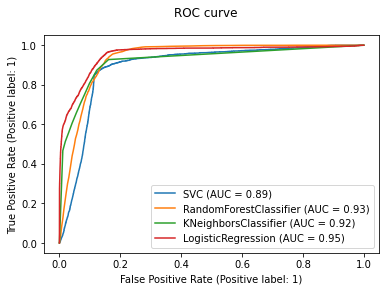

In [223]:

## Plotting the ROC AUC on the validation
svm_plot_1 = plot_roc_curve(svm, data_val, Y_val)
rfm_plot_1 = plot_roc_curve(rfm, data_val, Y_val, ax=svm_plot_1.ax_)
knn_plot_1= plot_roc_curve(knn, data_val, Y_val,ax=rfm_plot_1.ax_)
lr_plot_1 = plot_roc_curve(lr, data_val, Y_val, ax=knn_plot_1.ax_)
lr_plot_1.figure_.suptitle("ROC curve")

pyplot.show()

In [84]:
svm_AP = average_precision_score(Y_val, svm.decision_function(data_val))
rfm_AP =average_precision_score(Y_val, rfm.predict_proba(data_val)[:, 1])
lr_AP = average_precision_score(Y_val, lr.decision_function(data_val))
knn_AP = average_precision_score(Y_val, knn.predict_proba(data_val)[:, 1])
svm_AUC_1 = roc_auc_score(Y_val, svm.decision_function(data_val))
rfm_AUC_1 =roc_auc_score(Y_val, rfm.predict_proba(data_val)[:, 1])
lr_AUC_1 = roc_auc_score(Y_val, lr.decision_function(data_val))
knn_AUC_1 = roc_auc_score(Y_val, knn.predict_proba(data_val)[:, 1])



In [224]:
idx1=['SVM','RandomForestClassifier','LogisticRegression','KNeighborClassifier']
perf=pd.DataFrame({'ROC AUC':[svm_auc,rfm_auc,lr_auc, knn_auc],'Average Precision':[svm_ap,rfm_ap,lr_ap, knn_ap],'Precision@100': [svm_precisionat100, rfm_precisionat100,lr_precisionat100,knn_precisionat100], 'Precision@500':[svm_precisionat500,rfm_precisionat500,lr_precisionat500,knn_precisionat500], 'Precision@1000':[svm_precisionat1000,rfm_precisionat1000,lr_precisionat1000,knn_precisionat1000]  }, index=idx1)
perf

,ROC AUC,Average Precision,Precision@100,Precision@500,Precision@1000
SVM,0.892143,0.077793,0.04,0.040,0.051
RandomForestClassifier,0.933950,0.123073,0.09,0.130,0.135
LogisticRegression,0.954663,0.549381,1.00,0.998,0.830
KNeighborClassifier,0.922728,0.250962,0.34,0.382,0.380


In [77]:
svm_AUC_val_list=[]
rfm_AUC_val_list=[]
lr_AUC_val_list=[]
knn_AUC_val_list=[]

    # Performace Analysis of the number of observations
for i in range(10,101,10):
     
    # sampling X1
    sample = X1.sample(frac=i*0.01)
    Xval=sample.drop('Label',axis=1)
    Yval=sample['Label']
    scaler = StandardScaler()
    scaler.fit(Xval)
    Xval = scaler.transform(Xval)
    
    
    
    
    # Precision score
    
    svm_precision_score= svm.decision_function(Xval)
    lr_precision_score= lr.decision_function(Xval)

    
    # ROC AUC score
    svm_AUC = roc_auc_score(Yval, svm_precision_score)
    rfm_AUC = roc_auc_score(Yval, rfm.predict_proba(Xval)[:, 1])
    lr_AUC = roc_auc_score(Yval, lr_precision_score)
    knn_AUC = roc_auc_score(Yval, knn.predict_proba(Xval)[:, 1])
    
    
    # Adding the average precision score into a list for plotting
    svm_AUC_val_list.append(svm_AUC)
    rfm_AUC_val_list.append(rfm_AUC)
    lr_AUC_val_list.append(lr_AUC)
    knn_AUC_val_list.append(knn_AUC)
    

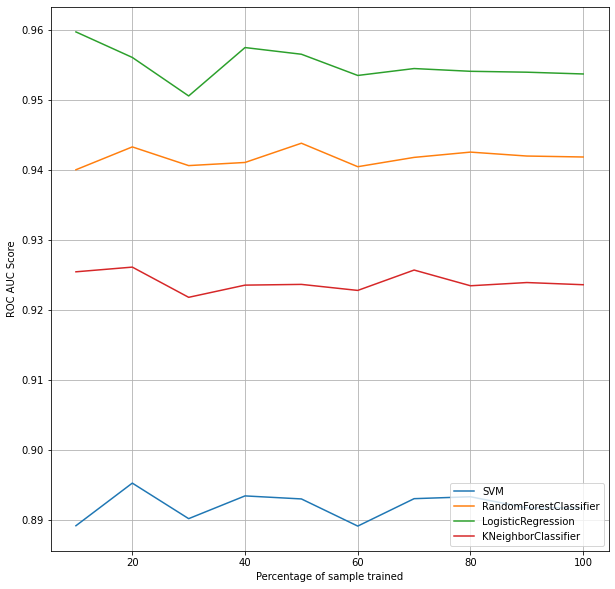

In [78]:
pyplot.figure(figsize=(10,10))
pyplot.plot(range(10,101,10),svm_AUC_val_list)
pyplot.plot(range(10,101,10),rfm_AUC_val_list)
pyplot.plot(range(10,101,10),lr_AUC_val_list)
pyplot.plot(range(10,101,10),knn_AUC_val_list)
pyplot.legend(["SVM","RandomForestClassifier","LogisticRegression","KNeighborClassifier"],fontsize=10,loc='lower right')
pyplot.grid(True)
pyplot.xticks()
pyplot.yticks()
pyplot.xlabel("Percentage of sample trained")
pyplot.ylabel("ROC AUC Score")
pyplot.show()

In [67]:
def precision_score(y_true, y_score, k=10):
    """Precision at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    Returns
    -------
    precision @k : float
    """
    unique_y = np.unique(y_true)

    if len(unique_y) > 2:
        raise ValueError("Only supported for two relevance levels.")

    pos_label = unique_y[1]
    n_pos = np.sum(y_true == pos_label)

    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    n_relevant = np.sum(y_true == pos_label)

    # Divide by min(n_pos, k) such that the best achievable score is always 1.0.
    return float(n_relevant) / min(n_pos, k)